# EDA on HAM10000 Dataset

# STAGE 1 - INITIAL EDA

This section performs Exploratory Data Analysis (EDA) on the HAM10000 skin cancer dataset.

IT:

1. Loads the metadata describing each image and its diagnosis.
2. Shows how many total samples and disease types exist.
3. Visualizes how evenly (or unevenly) the dataset’s classes are distributed.
4. Randomly displays a few example skin lesion images with their labels to help understand what the data looks like.

Total number of samples: 10015
Number of unique classes: 7

Class distribution:


dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

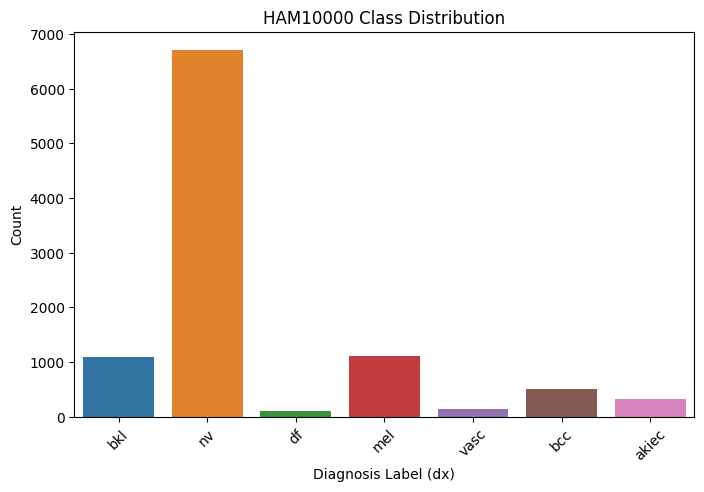

In [20]:
# =============================================
# EDA on HAM10000 Dataset
# =============================================

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Dataset paths
IMG_DIR = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images"
META_FILE = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv"

# Load metadata
metadata = pd.read_csv(META_FILE)

# Display basic dataset information
print("Total number of samples:", len(metadata))
print("Number of unique classes:", metadata['dx'].nunique())
print("\nClass distribution:")
display(metadata['dx'].value_counts())

# Visualize class distribution
plt.figure(figsize=(8,5))
sns.countplot(x='dx', data=metadata)
plt.xticks(rotation=45)
plt.title("HAM10000 Class Distribution")
plt.xlabel("Diagnosis Label (dx)")
plt.ylabel("Count")
plt.show()

# Display a few random sample images
for i, row in metadata.sample(5, random_state=42).iterrows():
    img_path = os.path.join(IMG_DIR, row['image_id'] + ".jpg")
    if os.path.exists(img_path):
        img = Image.open(img_path)
        plt.figure()
        plt.imshow(img)
        plt.title(f"Diagnosis: {row['dx']}")
        plt.axis('off')
        plt.show()


# STAGE 2 - Image Quality Assessment

Metadata shape: (10015, 7)
Columns: ['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization']

Total files in image folder: 9
Unique images listed in metadata: 10015

Sample mapping check (first 12 image IDs):
ISIC_0027419 -> MISSING
ISIC_0025030 -> MISSING
ISIC_0026769 -> MISSING
ISIC_0025661 -> MISSING
ISIC_0031633 -> MISSING
ISIC_0027850 -> MISSING
ISIC_0029176 -> MISSING
ISIC_0029068 -> MISSING
ISIC_0025837 -> MISSING
ISIC_0025209 -> MISSING
ISIC_0025276 -> MISSING
ISIC_0029396 -> MISSING


100%|██████████| 10015/10015 [00:00<00:00, 135646.16it/s]


Total valid images checked: 0

Distribution of classes (number of images per class):
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


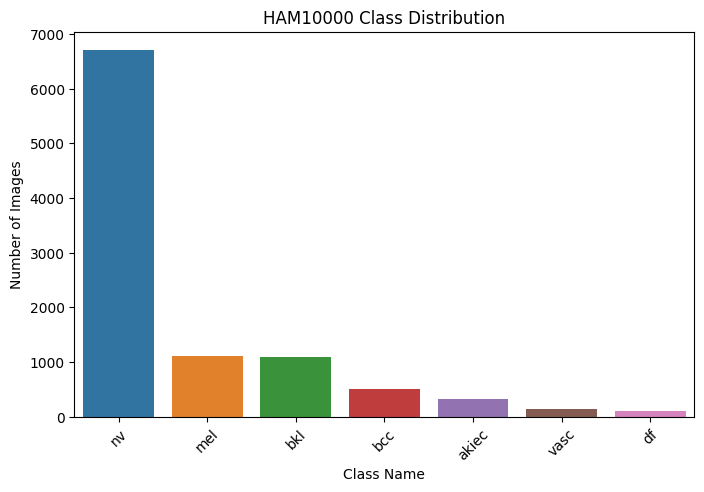

In [21]:
# =============================================
# HAM10000 Dataset Analysis (EDA + Quality Check)
# =============================================

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from PIL import Image

# -----------------------------
# Dataset Paths
# -----------------------------
IMG_DIR = "/kaggle/input/skin-cancer-mnist-ham10000"
META_FILE = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv"

# -----------------------------
# Load Metadata
# -----------------------------
metadata = pd.read_csv(META_FILE)
print(f"Metadata shape: {metadata.shape}")
print(f"Columns: {list(metadata.columns)}\n")

# -----------------------------
# File Check
# -----------------------------
all_files = os.listdir(IMG_DIR)
jpg_files = [f for f in all_files if f.lower().endswith(".jpg")]
print(f"Total files in image folder: {len(all_files)}")
print(f"Unique images listed in metadata: {metadata['image_id'].nunique()}")

# Verify mapping for a few samples
print("\nSample mapping check (first 12 image IDs):")
for img_id in metadata['image_id'].head(12):
    img_path = os.path.join(IMG_DIR, img_id + ".jpg")
    print(f"{img_id} -> {'FOUND' if os.path.exists(img_path) else 'MISSING'}")

# -----------------------------
# Image Quality Check
# -----------------------------
widths, heights, bad_images = [], [], []

for img_id in tqdm(metadata['image_id'], total=len(metadata)):
    img_path = os.path.join(IMG_DIR, img_id + ".jpg")
    try:
        with Image.open(img_path) as img:
            widths.append(img.width)
            heights.append(img.height)
    except:
        bad_images.append(img_path)

print(f"\nTotal valid images checked: {len(widths)}")

if len(widths) > 0:
    print(f"Average width: {sum(widths)/len(widths):.2f} px")
    print(f"Average height: {sum(heights)/len(heights):.2f} px")
    print(f"Min/Max width: {min(widths)}/{max(widths)} px")
    print(f"Min/Max height: {min(heights)}/{max(heights)} px")

# -----------------------------
# Class Distribution
# -----------------------------
class_counts = metadata['dx'].value_counts()
print("\nDistribution of classes (number of images per class):")
print(class_counts)

# Plot class distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title("HAM10000 Class Distribution")
plt.xlabel("Class Name")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()


# Stage 4 & 5 - Resolve Image Paths + Pixel Statistics + Visualization

This section performs advanced exploratory analysis and quality assessment of the HAM10000 dataset:

1. Loads and previews the metadata.
2. Finds and maps image paths from multiple folders.
3. Computes pixel-level statistics for each image (mean, std, min, max for RGB channels).
4. Visualizes distributions of pixel brightness, color balance, and contrast variations.
5. Merges the results with the original metadata.
6. Calculates average RGB values per diagnosis type, showing how color characteristics differ between skin lesion
categories.
7. Saves the resulting DataFrames for further use in model training and normalization.

**This step helps ensure image consistency and identify potential color biases across different classes — a key step before preprocessing or deep learning model training.**

Metadata shape: (10015, 7)


lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

Missing image files: 0
Total unique image files available for statistics: 10015


Computing per-image pixel statistics: 100%|██████████| 500/500 [00:38<00:00, 13.10it/s]


### Summary of Per-Image Statistics (Sample)

count      mean       std       min       max
mean_R  500.0  0.689069  0.087348  0.437708  0.907372
mean_G  500.0  0.559121  0.074033  0.348447  0.799709
mean_B  500.0  0.592285  0.075858  0.373526  0.820367
std_R   500.0  0.097371  0.052599  0.019995  0.306174
std_G   500.0  0.119184  0.049166  0.034905  0.303790
std_B   500.0  0.136949  0.050124  0.043935  0.321247
min_R   500.0  0.137271  0.137619  0.000000  0.682353
min_G   500.0  0.057137  0.069945  0.000000  0.498039
min_B   500.0  0.047882  0.066285  0.000000  0.466667
max_R   500.0  0.883325  0.084937  0.698039  1.000000
max_G   500.0  0.836173  0.098073  0.611765  1.000000
max_B   500.0  0.896533  0.084204  0.662745  1.000000

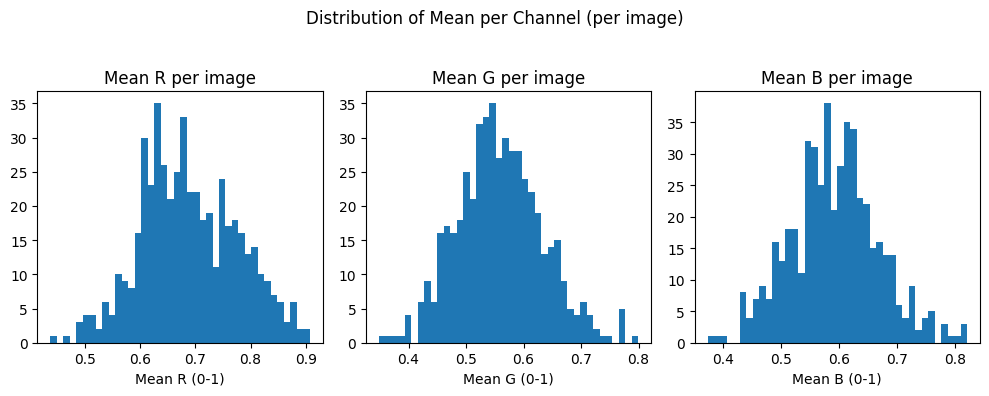

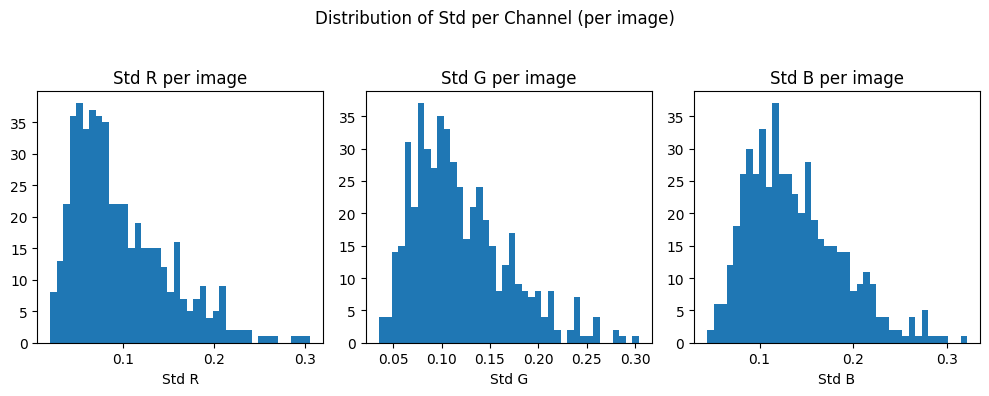

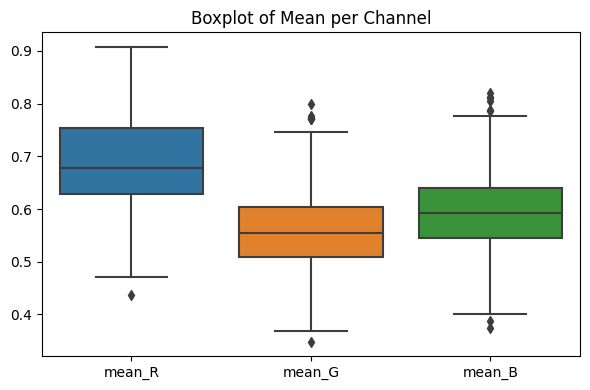

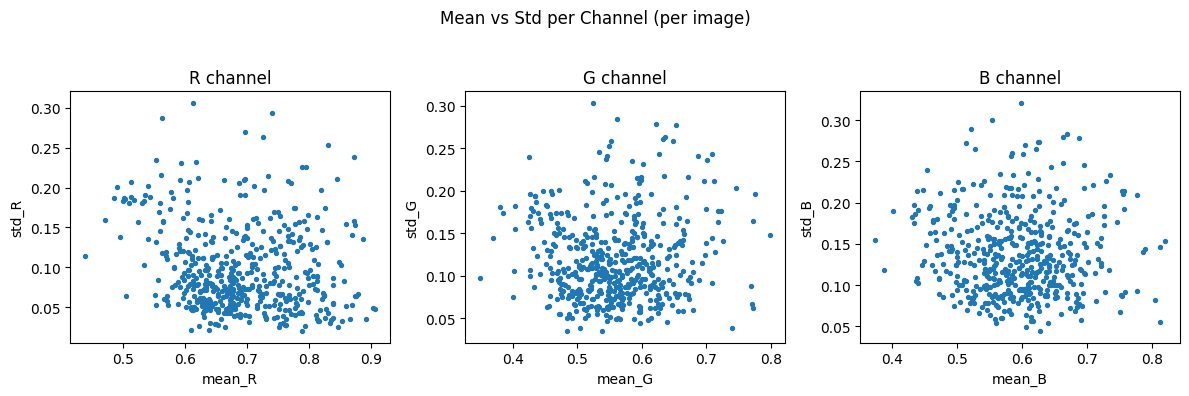

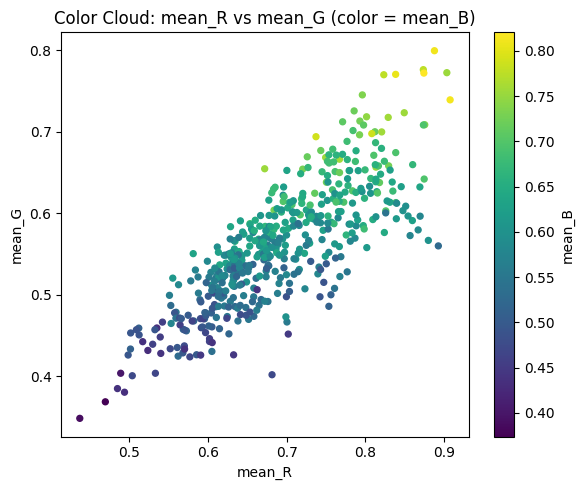

Merged statistics into metadata: 10015 rows


#### Mean RGB per Diagnosis (Average Across Images)

mean_R  mean_G  mean_B
dx                           
akiec  0.0000  0.0000  0.0000
bcc    0.0000  0.0000  0.0000
bkl    0.6891  0.5591  0.5921
df     0.0000  0.0000  0.0000
mel    0.0000  0.0000  0.0000
nv     0.6838  0.5803  0.6684
vasc   0.0000  0.0000  0.0000

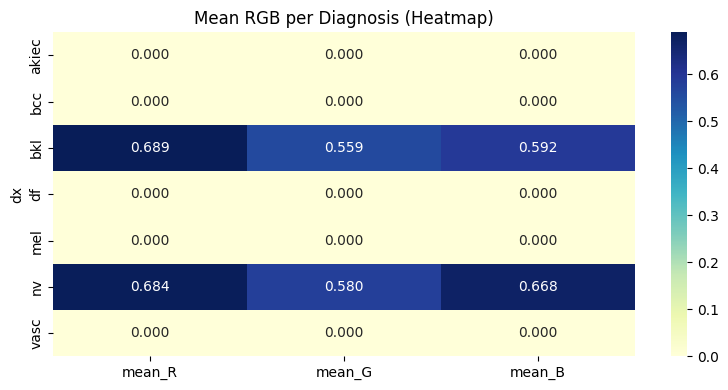


✅ Stage 4 & 5 completed. Objects `stats_df` and `stats_merged` are available.


In [22]:
# =============================================
# Stage 4 & 5: Resolve Image Paths + Pixel Statistics + Visualization
# (Supports Multiple Folders)
# =============================================

import os
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

# ---------- 1. Load Metadata ----------
META_FILE = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv"
metadata = pd.read_csv(META_FILE)
print(f"Metadata shape: {metadata.shape}")
display(metadata.head())

# ---------- 2. Resolve Image Paths from Multiple Folders ----------
IMG_DIRS = [
    "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1",
    "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2"
]

# Create image_path column
def find_image_path(image_id):
    for d in IMG_DIRS:
        p = os.path.join(d, f"{image_id}.jpg")
        if os.path.exists(p):
            return p
    return None

metadata['image_path'] = metadata['image_id'].apply(find_image_path)

# Check for missing files
missing = metadata['image_path'].isna().sum()
print(f"Missing image files: {missing}")
if missing > 0:
    print("Example of missing image IDs:", metadata.loc[metadata['image_path'].isna(), 'image_id'].head().tolist())

# ---------- 3. Per-Image Pixel Statistics ----------
all_paths = metadata['image_path'].dropna().unique().tolist()
n_all = len(all_paths)
print("Total unique image files available for statistics:", n_all)

SAMPLE_N = 500  # Change to None to process all images
paths = all_paths if SAMPLE_N is None or SAMPLE_N >= n_all else all_paths[:SAMPLE_N]

per_image_stats = []
for p in tqdm(paths, desc="Computing per-image pixel statistics"):
    try:
        img = cv2.imread(p)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
        pixels = img.reshape(-1, 3)
        mean_c = pixels.mean(axis=0)
        std_c  = pixels.std(axis=0)
        min_c  = pixels.min(axis=0)
        max_c  = pixels.max(axis=0)
        per_image_stats.append({
            'path': str(p),
            'mean_R': float(mean_c[0]), 'mean_G': float(mean_c[1]), 'mean_B': float(mean_c[2]),
            'std_R' : float(std_c[0]),  'std_G' : float(std_c[1]),  'std_B' : float(std_c[2]),
            'min_R' : float(min_c[0]),  'min_G' : float(min_c[1]),  'min_B' : float(min_c[2]),
            'max_R' : float(max_c[0]),  'max_G' : float(max_c[1]),  'max_B' : float(max_c[2]),
        })
    except Exception:
        continue

stats_df = pd.DataFrame(per_image_stats)
if stats_df.empty:
    raise RuntimeError("All files failed to load. Ensure dataset files are present.")

display(Markdown("### Summary of Per-Image Statistics (Sample)"))
display(stats_df.describe().T[['count', 'mean', 'std', 'min', 'max']])

# ---------- 4. Visualization ----------
# Histograms of mean per channel
plt.figure(figsize=(10,4))
plt.subplot(1,3,1); plt.hist(stats_df['mean_R'], bins=40); plt.title('Mean R per image'); plt.xlabel('Mean R (0-1)')
plt.subplot(1,3,2); plt.hist(stats_df['mean_G'], bins=40); plt.title('Mean G per image'); plt.xlabel('Mean G (0-1)')
plt.subplot(1,3,3); plt.hist(stats_df['mean_B'], bins=40); plt.title('Mean B per image'); plt.xlabel('Mean B (0-1)')
plt.suptitle('Distribution of Mean per Channel (per image)'); plt.tight_layout(rect=[0,0,1,0.95]); plt.show()

# Histograms of std per channel
plt.figure(figsize=(10,4))
plt.subplot(1,3,1); plt.hist(stats_df['std_R'], bins=40); plt.title('Std R per image'); plt.xlabel('Std R')
plt.subplot(1,3,2); plt.hist(stats_df['std_G'], bins=40); plt.title('Std G per image'); plt.xlabel('Std G')
plt.subplot(1,3,3); plt.hist(stats_df['std_B'], bins=40); plt.title('Std B per image'); plt.xlabel('Std B')
plt.suptitle('Distribution of Std per Channel (per image)'); plt.tight_layout(rect=[0,0,1,0.95]); plt.show()

# Boxplot of mean per channel
plt.figure(figsize=(6,4))
sns.boxplot(data=stats_df[['mean_R', 'mean_G', 'mean_B']])
plt.xticks([0,1,2], ['mean_R', 'mean_G', 'mean_B'])
plt.title("Boxplot of Mean per Channel")
plt.tight_layout(); plt.show()

# Scatter plots: mean vs std per channel
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.scatter(stats_df['mean_R'], stats_df['std_R'], s=8); plt.xlabel('mean_R'); plt.ylabel('std_R'); plt.title('R channel')
plt.subplot(1,3,2); plt.scatter(stats_df['mean_G'], stats_df['std_G'], s=8); plt.xlabel('mean_G'); plt.ylabel('std_G'); plt.title('G channel')
plt.subplot(1,3,3); plt.scatter(stats_df['mean_B'], stats_df['std_B'], s=8); plt.xlabel('mean_B'); plt.ylabel('std_B'); plt.title('B channel')
plt.suptitle('Mean vs Std per Channel (per image)'); plt.tight_layout(rect=[0,0,1,0.95]); plt.show()

# Color cloud visualization
plt.figure(figsize=(6,5))
sc = plt.scatter(stats_df['mean_R'], stats_df['mean_G'], c=stats_df['mean_B'], s=18)
plt.colorbar(sc, label='mean_B')
plt.xlabel('mean_R'); plt.ylabel('mean_G'); plt.title('Color Cloud: mean_R vs mean_G (color = mean_B)')
plt.tight_layout(); plt.show()

# ---------- 5. Merge Statistics into Metadata ----------
stats_df['stem'] = stats_df['path'].apply(lambda x: os.path.basename(x).split('.')[0])
metadata['stem'] = metadata['image_id'].astype(str)

merged = metadata.merge(stats_df, on='stem', how='left')
print(f"Merged statistics into metadata: {merged.shape[0]} rows")

# Per-class mean RGB
per_class_mean = merged.groupby('dx')[['mean_R','mean_G','mean_B']].mean().fillna(0)
display(Markdown("#### Mean RGB per Diagnosis (Average Across Images)"))
display(per_class_mean.round(4))

plt.figure(figsize=(8, max(4, 0.25*len(per_class_mean))))
sns.heatmap(per_class_mean, annot=True, fmt='.3f', cmap='YlGnBu')
plt.title("Mean RGB per Diagnosis (Heatmap)")
plt.tight_layout(); plt.show()

# ---------- Save Objects ----------
globals()['stats_df'] = stats_df
globals()['stats_merged'] = merged
print("\n✅ Stage 4 & 5 completed. Objects `stats_df` and `stats_merged` are available.")


# STAGE 6 - Visualise sample images from each class

This section visualizes random example images from each diagnosis class in the HAM10000 dataset.
It helps confirm that:

1. Each class contains valid and properly mapped image files.
2. The visual appearance of skin lesions differs across classes.
3. No missing or corrupted images exist.

For every class, five sample images are displayed side by side with their image_id labels.

This visual check ensures the dataset is properly loaded and ready for preprocessing or model training.

Displaying 5 sample images per class:


### Class: bkl

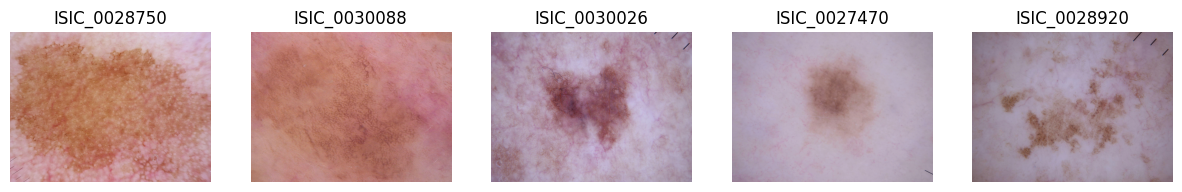

### Class: nv

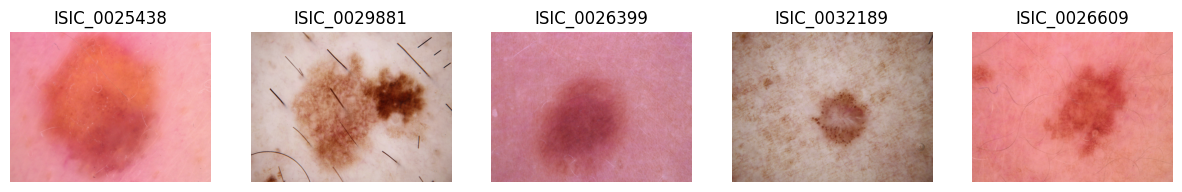

### Class: df

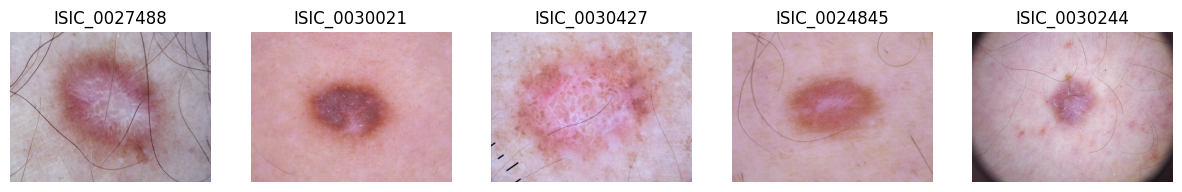

### Class: mel

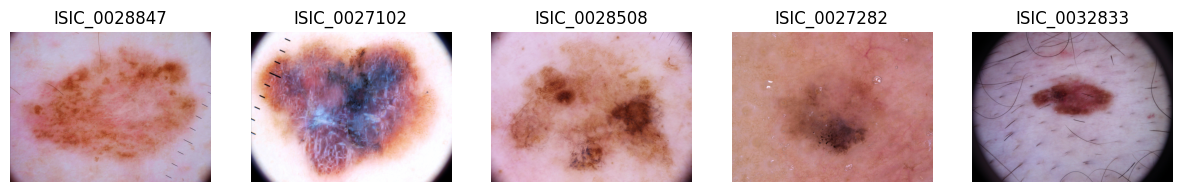

### Class: vasc

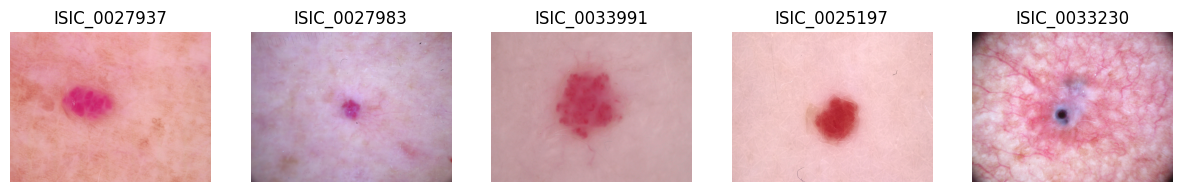

### Class: bcc

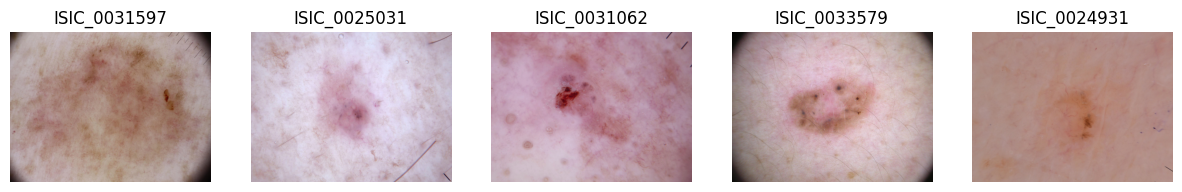

### Class: akiec

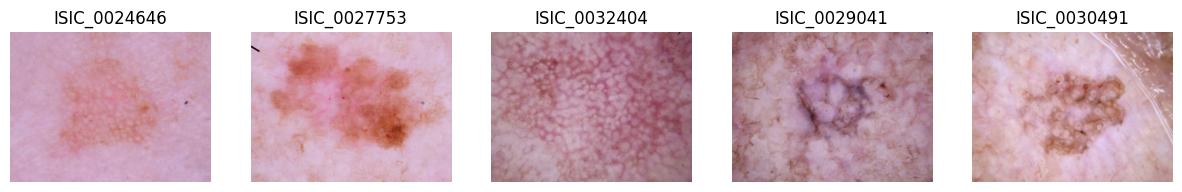

In [9]:
# =============================================
# Visualize Sample Images per Class
# =============================================

import matplotlib.pyplot as plt
import random
from IPython.display import display, Markdown

# Number of samples to display per class
SAMPLES_PER_CLASS = 5

# Get unique diagnosis classes
classes = stats_merged['dx'].unique()

print(f"Displaying {SAMPLES_PER_CLASS} sample images per class:")
for cls in classes:
    display(Markdown(f"### Class: {cls}"))
    cls_rows = stats_merged[stats_merged['dx'] == cls].dropna(subset=['image_path'])
    sample_rows = cls_rows.sample(n=min(SAMPLES_PER_CLASS, len(cls_rows)), random_state=42)
    
    plt.figure(figsize=(15, 3))
    for i, (_, row) in enumerate(sample_rows.iterrows()):
        img = cv2.imread(row['image_path'])
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, SAMPLES_PER_CLASS, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(row['image_id'])
    plt.show()


# STAGE 7 - Metadata Correlation Analysis

This section performs correlation analysis on the HAM10000 metadata to explore possible relationships between patient information and diagnosis type.

Steps include:

1. Loading the metadata and examining its structure.
2. Encoding categorical features (sex, localization, dx) into numerical form for analysis.
3. Selecting relevant numeric columns, including patient age and encoded categorical fields.
4. Calculating the correlation matrix to measure relationships among variables.
5. Visualizing correlations with a Seaborn heatmap for easy interpretation.

The resulting matrix highlights potential dependencies — for example, whether certain lesion locations or patient ages are more associated with specific skin conditions.

Metadata shape: (10015, 7)


lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

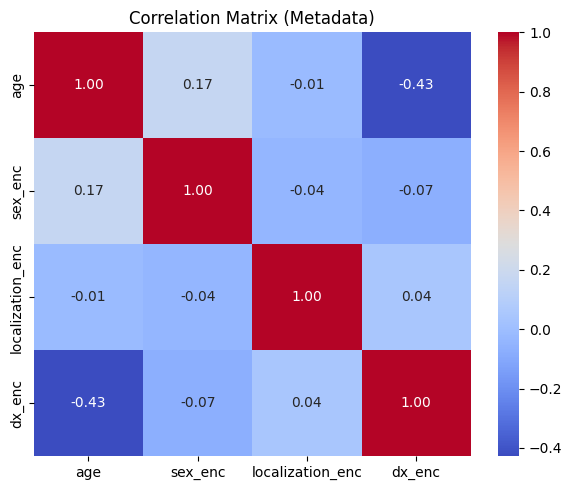

age   sex_enc  localization_enc    dx_enc
age               1.000000  0.167984         -0.014926 -0.427441
sex_enc           0.167984  1.000000         -0.039845 -0.073130
localization_enc -0.014926 -0.039845          1.000000  0.042260
dx_enc           -0.427441 -0.073130          0.042260  1.000000

In [10]:
# =============================================
# Metadata Correlation Analysis (EDA)
# =============================================

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from IPython.display import display

# 1. Load Metadata
meta = pd.read_csv("/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv")
print("Metadata shape:", meta.shape)
display(meta.head())

# 2. Encode Categorical Columns
cat_cols = ['sex', 'localization', 'dx']
for c in cat_cols:
    le = LabelEncoder()
    meta[c + '_enc'] = le.fit_transform(meta[c].astype(str))

# 3. Select Numeric / Encoded Columns
num_cols = ['age'] + [c + '_enc' for c in cat_cols]

# 4. Compute Correlation Matrix
corr_matrix = meta[num_cols].corr()

# 5. Visualize Correlation Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix (Metadata)")
plt.tight_layout()
plt.show()

# 6. Display Correlation Table
display(corr_matrix)


# STAGE 8 - Leakage Checking

This section checks for data leakage in the HAM10000 dataset — ensuring that multiple images of the same lesion do not appear in both training and testing sets.

Steps include:

1. Loading the dataset metadata.

2. Splitting data by lesion_id instead of by individual images.

3. Creating separate train, validation, and test DataFrames.

4. Checking for overlap between these sets to detect leakage.

5. Confirming that the final split is safe.

This step is critical for maintaining model validity — it ensures that the model learns to generalize to new lesions rather than memorizing images of the same one.

In [11]:
# =============================================
# Data Leakage Checking
# =============================================

import pandas as pd
from sklearn.model_selection import train_test_split

# Ensure metadata is loaded
# You can replace this with your merged dataset if available
meta_merged = pd.read_csv("/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv")

# Split the dataset into train / validation / test sets
# Use lesion_id to prevent data leakage (same lesion appearing in multiple sets)
unique_lesions = meta_merged['lesion_id'].unique()
train_lesions, testval_lesions = train_test_split(unique_lesions, test_size=0.3, random_state=42)
val_lesions, test_lesions = train_test_split(testval_lesions, test_size=0.5, random_state=42)

# Create splits based on lesion_id
train = meta_merged[meta_merged['lesion_id'].isin(train_lesions)]
val   = meta_merged[meta_merged['lesion_id'].isin(val_lesions)]
test  = meta_merged[meta_merged['lesion_id'].isin(test_lesions)]

# Print number of samples per split
print("Number of samples per split:")
print("Train:", len(train))
print("Validation:", len(val))
print("Test:", len(test))

# -------------------------------------
# Check for potential data leakage
# -------------------------------------
overlap_train_val   = set(train['lesion_id']).intersection(val['lesion_id'])
overlap_train_test  = set(train['lesion_id']).intersection(test['lesion_id'])
overlap_val_test    = set(val['lesion_id']).intersection(test['lesion_id'])

print("\nOverlap between Train and Validation:", overlap_train_val)
print("Overlap between Train and Test:", overlap_train_test)
print("Overlap between Validation and Test:", overlap_val_test)

# Evaluate safety of split
if not overlap_train_val and not overlap_train_test and not overlap_val_test:
    print("\n✅ No data leakage detected. Split is safe.")
else:
    print("\n⚠️ Potential data leakage detected! Please recheck your split.")


Number of samples per split:
Train: 6987
Validation: 1512
Test: 1516

Overlap between Train and Validation: set()
Overlap between Train and Test: set()
Overlap between Validation and Test: set()

✅ No data leakage detected. Split is safe.


**Dataset Spliting**

# Dataset Splitting Script -> test,train,val 

Creating three subsets:

* 70% Training
* 15% Validation
* 15% Testing

In [12]:
# =============================================
# Dataset Splitting (Train / Validation / Test)
# =============================================

import pandas as pd
from sklearn.model_selection import train_test_split

# Load metadata
meta = pd.read_csv("/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv")
print("Total samples:", len(meta))

# -----------------------------
# Split by lesion_id (to prevent data leakage)
# -----------------------------
# Get unique lesion IDs
unique_lesions = meta['lesion_id'].unique()

# Split: 70% Train, 30% Val+Test
train_lesions, val_test_lesions = train_test_split(unique_lesions, test_size=0.3, random_state=42)

# Split remaining 30% equally into 15% Validation, 15% Test
val_lesions, test_lesions = train_test_split(val_test_lesions, test_size=0.5, random_state=42)

# -----------------------------
# Create DataFrames for each split
# -----------------------------
train = meta[meta['lesion_id'].isin(train_lesions)].reset_index(drop=True)
val   = meta[meta['lesion_id'].isin(val_lesions)].reset_index(drop=True)
test  = meta[meta['lesion_id'].isin(test_lesions)].reset_index(drop=True)

print("Number of samples per split:")
print("Train:", len(train))
print("Validation:", len(val))
print("Test:", len(test))

# -----------------------------
# Check class distribution per split
# -----------------------------
print("\nClass distribution (Train):")
print(train['dx'].value_counts())

print("\nClass distribution (Validation):")
print(val['dx'].value_counts())

print("\nClass distribution (Test):")
print(test['dx'].value_counts())

# -----------------------------
# Optional: Save splits to CSV
# -----------------------------
train.to_csv("train_split.csv", index=False)
val.to_csv("val_split.csv", index=False)
test.to_csv("test_split.csv", index=False)

print("\n✅ Dataset split completed and CSV files saved successfully.")


Total samples: 10015
Number of samples per split:
Train: 6987
Validation: 1512
Test: 1516

Class distribution (Train):
dx
nv       4728
mel       775
bkl       734
bcc       355
akiec     235
vasc       85
df         75
Name: count, dtype: int64

Class distribution (Validation):
dx
nv       958
mel      193
bkl      180
bcc       82
vasc      41
akiec     41
df        17
Name: count, dtype: int64

Class distribution (Test):
dx
nv       1019
bkl       185
mel       145
bcc        77
akiec      51
df         23
vasc       16
Name: count, dtype: int64

✅ Dataset split completed and CSV files saved successfully.


# Image preprocessing and augmentation

This section defines preprocessing pipelines for training, validation, and test data using TorchVision transforms.

1. Training transforms include random rotations, flips, and color jittering to improve the model’s ability to generalize.
2. Validation/test transforms only perform resizing and normalization to maintain consistent evaluation conditions.
3. Images are converted into normalized PyTorch tensors ready for input into a deep learning model (e.g. ResNet, EfficientNet).

**This preprocessing ensures all images have the same dimensions, color scale, and normalization, which is essential for stable model performance.**

In [13]:
# =============================================
# Preprocessing Setup (TorchVision)
# =============================================

import torchvision.transforms as T
from PIL import Image

# 1. Transformations for training (with augmentation)
train_transforms = T.Compose([
    T.Resize((224, 224)),                # Resize all images
    T.RandomHorizontalFlip(),            # Random horizontal flip
    T.RandomVerticalFlip(),              # Random vertical flip
    T.RandomRotation(20),                # Random rotation within ±20 degrees
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Random color adjustments
    T.ToTensor(),                        # Convert image to PyTorch tensor [C, H, W]
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])        # Normalize to [-1, 1]
])

# 2. Transformations for validation / testing (no augmentation)
val_test_transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# 3. Example usage: load and transform a single image
sample_path = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0027419.jpg"
img = Image.open(sample_path).convert('RGB')   # Ensure RGB format
img_tensor = train_transforms(img)             # Apply transformations

print("Tensor shape:", img_tensor.shape)
print("Min / Max pixel values:", img_tensor.min().item(), img_tensor.max().item())


Tensor shape: torch.Size([3, 224, 224])
Min / Max pixel values: -1.0 0.7254902124404907


# Mean & Standard Deviation per Channel

This section computes the mean and standard deviation of pixel intensities for each color channel (R, G, B) in the HAM10000 28×28 RGB dataset.

Steps include:

Loading the flattened dataset from CSV.

Normalizing pixel values to a 0–1 range.

Separating the pixel data into R, G, and B channels.

Calculating the mean and standard deviation for each channel.

These values are later used in image normalization, a preprocessing step that standardizes all images so each channel has a similar distribution. This helps the neural network train more effectively and converge faster.

In [14]:
import pandas as pd
import numpy as np

# Load the flattened 28x28 RGB dataset
rgb_csv = "/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv"
df_rgb = pd.read_csv(rgb_csv)
print("RGB CSV shape:", df_rgb.shape)
display(df_rgb.head())

# Extract pixel values (exclude label column)
# CSV format: label, r0, r1,..., g0, g1,..., b0, b1,...
pixel_cols = df_rgb.columns.drop('label')
pixels = df_rgb[pixel_cols].values.astype(np.float32) / 255.0  # Normalize to 0-1

# Split into R, G, B channels
n_pixels = 28 * 28
R = pixels[:, :n_pixels]
G = pixels[:, n_pixels:2*n_pixels]
B = pixels[:, 2*n_pixels:3*n_pixels]

# Compute mean and standard deviation for each channel
mean_R = R.mean()
mean_G = G.mean()
mean_B = B.mean()
std_R  = R.std()
std_G  = G.std()
std_B  = B.std()

print("Mean per channel (R, G, B):", [mean_R, mean_G, mean_B])
print("Standard deviation per channel (R, G, B):", [std_R, std_G, std_B])


RGB CSV shape: (10015, 2353)


pixel0000  pixel0001  pixel0002  pixel0003  pixel0004  pixel0005  \
0        192        153        193        195        155        192   
1         25         14         30         68         48         75   
2        192        138        153        200        145        163   
3         38         19         30         95         59         72   
4        158        113        139        194        144        174   

   pixel0006  pixel0007  pixel0008  pixel0009  ...  pixel2343  pixel2344  \
0        197        154        185        202  ...        173        124   
1        123         93        126        158  ...         60         39   
2        201        142        160        206  ...        167        129   
3        143        103        119        171  ...         44         26   
4        215        162        191        225  ...        209        166   

   pixel2345  pixel2346  pixel2347  pixel2348  pixel2349  pixel2350  \
0        138        183        147        166        185        154   
1         55         25         14         28         25         14   
2        143        159        124        142        136        104   
3         36         25         12         17         25         12   
4        185        172        135        149        109         78   

   pixel2351  label  
0        177      2  
1         27      2  
2        117      2  
3         15      2  
4         92      2  

[5 rows x 2353 columns]

Mean per channel (R, G, B): [0.6544268, 0.5839606, 0.64201015]
Standard deviation per channel (R, G, B): [0.1680434, 0.2009493, 0.16399746]


# Custom preprocessing function for medical images

This function performs a complete preprocessing pipeline for medical skin lesion images from the HAM10000 dataset.
It includes:

1. Hair removal to eliminate visual artifacts using morphological operations and inpainting.
2. Contrast enhancement (CLAHE) to improve lesion visibility in uneven lighting.
3. Resizing and optional cropping to standardize input dimensions.
4. Normalization or standardization using dataset-specific mean and standard deviation.

These steps significantly enhance data quality, ensuring consistent illumination, contrast, and size - leading to more robust deep learning performance.

Processed image shape: (224, 224, 3)
Pixel min/max: -2.9323587258891943 2.7870227161206693


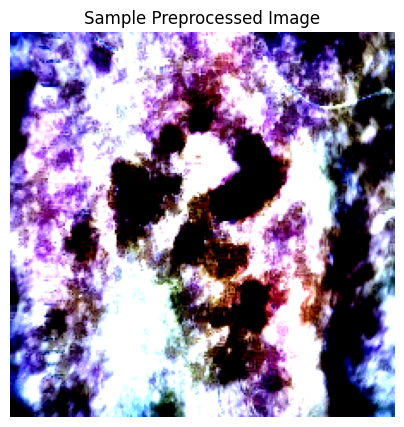

In [15]:
# =============================================
# Medical Image Preprocessing Function (HAM10000)
# =============================================

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def preprocess_image(
    img_path,
    resize_shape=(224, 224),
    normalize=True,
    mean_std=None,
    hair_removal=True,
    clahe=True,
    crop_shape=None
):
    """
    Preprocess a single medical image:
    - Resize
    - Optional: Hair removal
    - Optional: CLAHE contrast enhancement
    - Optional: Center crop
    - Normalize or standardize

    Args:
        img_path (str): Path to the image file
        resize_shape (tuple): Target size (H, W)
        normalize (bool): Scale pixel values to 0–1
        mean_std (dict): {'mean': [R,G,B], 'std': [R,G,B]} for standardization
        hair_removal (bool): Apply hair removal if True
        clahe (bool): Apply CLAHE if True
        crop_shape (tuple): Optional (H_crop, W_crop) for center crop

    Returns:
        img_proc (np.array): Preprocessed RGB image (float32)
    """
    # Read image
    img = cv2.imread(img_path)
    if img is None:
        raise RuntimeError(f"Cannot read image: {img_path}")

    # Convert BGR → RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize
    img = cv2.resize(img, resize_shape, interpolation=cv2.INTER_AREA)

    # Hair removal
    if hair_removal:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
        blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
        _, mask = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)
        img = cv2.inpaint(img, mask, 1, cv2.INPAINT_TELEA)

    # CLAHE contrast enhancement
    if clahe:
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        clahe_proc = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        l = clahe_proc.apply(l)
        lab = cv2.merge([l, a, b])
        img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

    # Center crop (optional)
    if crop_shape is not None:
        h, w = img.shape[:2]
        ch, cw = crop_shape
        start_h = max((h - ch) // 2, 0)
        start_w = max((w - cw) // 2, 0)
        img = img[start_h:start_h + ch, start_w:start_w + cw]

    # Convert to float32 and normalize
    img = img.astype(np.float32)
    if normalize:
        img /= 255.0
    if mean_std is not None:
        mean = np.array(mean_std['mean']).reshape(1, 1, 3)
        std = np.array(mean_std['std']).reshape(1, 1, 3)
        img = (img - mean) / std

    return img


# =============================================
# Example Usage: Visualize One Preprocessed Image
# =============================================
mean_std_train = {
    'mean': [0.709, 0.545, 0.574],  # Replace with actual training set values
    'std':  [0.140, 0.152, 0.169]
}

sample_img_path = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0027419.jpg"
img_proc = preprocess_image(
    sample_img_path,
    resize_shape=(224, 224),
    normalize=True,
    mean_std=mean_std_train,
    hair_removal=True,
    clahe=True,
    crop_shape=None
)

print("Processed image shape:", img_proc.shape)
print("Pixel min/max:", img_proc.min(), img_proc.max())

# Display processed image
plt.figure(figsize=(5, 5))
plt.imshow(np.clip(img_proc, 0, 1))
plt.axis('off')
plt.title("Sample Preprocessed Image")
plt.show()


# Demonstration of the full preprocessing pipeline


Sample image paths: ['/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0027891.jpg', '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2/ISIC_0034295.jpg', '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028904.jpg', '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2/ISIC_0029953.jpg', '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028231.jpg']


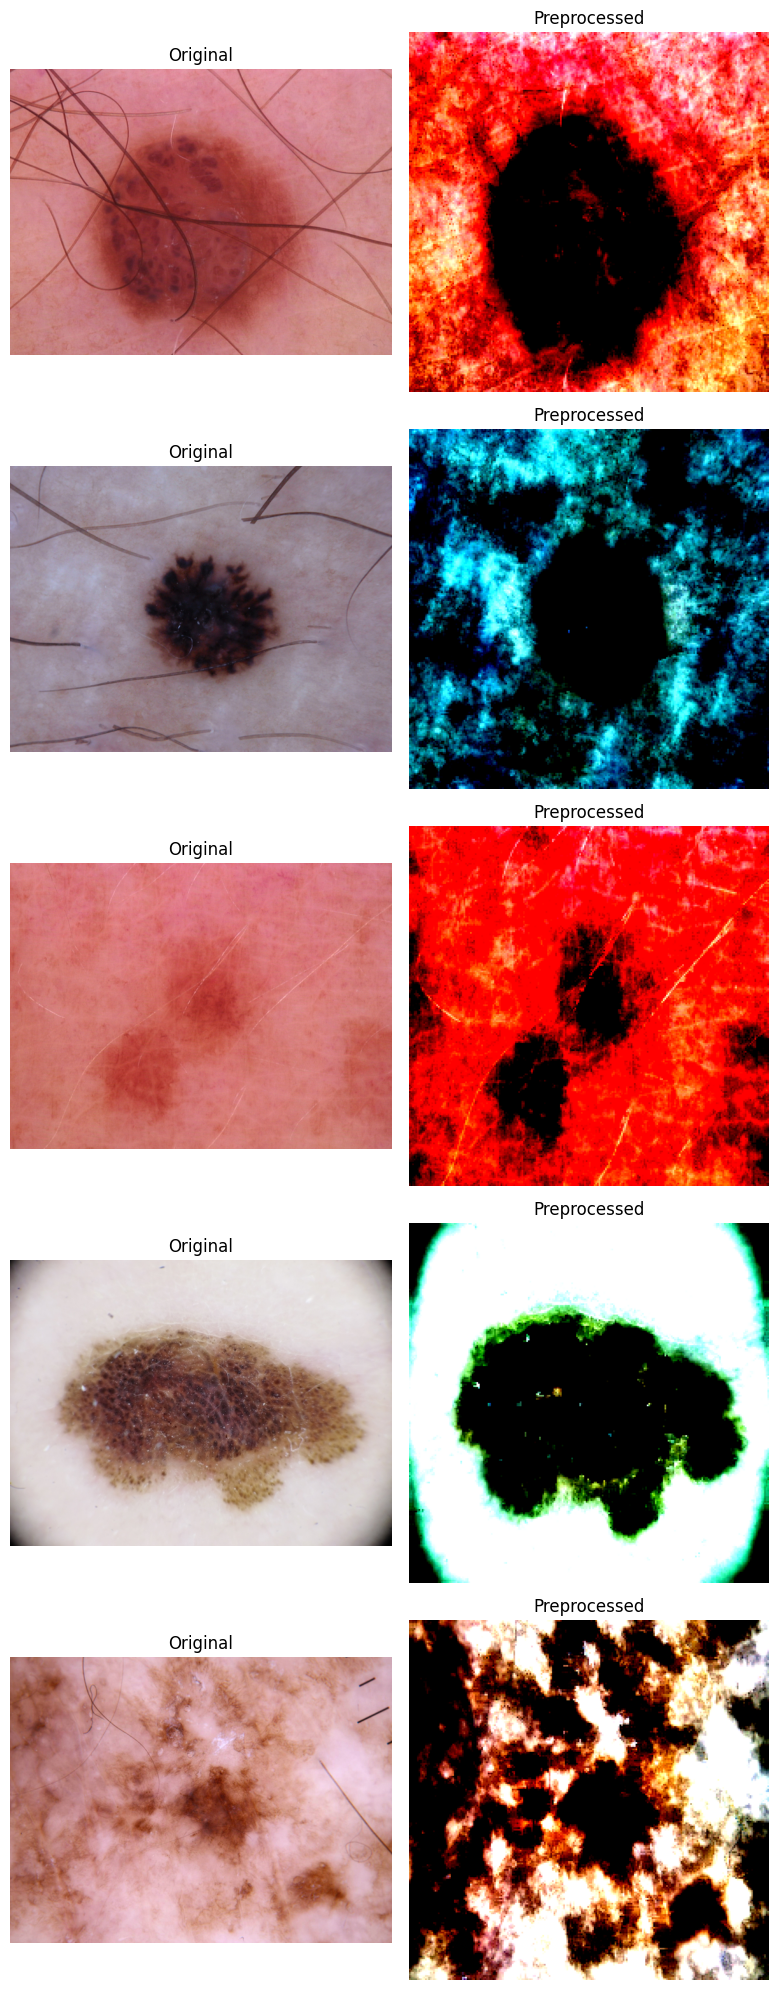

Torch tensor shape: torch.Size([3, 224, 224])
Tensor min/max values: -3.43072772026062 2.427891969680786


In [16]:
# =============================================
# Demonstration: Preprocessing Pipeline + Visualization
# =============================================

import os
import random
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

# ---------- Sample Image Selection ----------
IMG_DIR_PART1 = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1"
IMG_DIR_PART2 = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2"

# Randomly select 5 sample images
all_files = os.listdir(IMG_DIR_PART1) + os.listdir(IMG_DIR_PART2)
sample_files = random.sample(all_files, 5)

# Construct full paths for the selected samples
sample_paths = [
    os.path.join(IMG_DIR_PART1 if f in os.listdir(IMG_DIR_PART1) else IMG_DIR_PART2, f)
    for f in sample_files
]

print("Sample image paths:", sample_paths)

# ---------- Visualization: BEFORE vs AFTER Preprocessing ----------
fig, axes = plt.subplots(len(sample_paths), 2, figsize=(8, 4 * len(sample_paths)))

mean_std_train = {'mean': [0.709, 0.545, 0.574], 'std': [0.140, 0.152, 0.169]}

for i, path in enumerate(sample_paths):
    # BEFORE preprocessing
    img_orig = cv2.imread(path)
    img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)

    # AFTER preprocessing
    img_proc = preprocess_image(
        path,
        resize_shape=(224, 224),
        normalize=True,
        mean_std=mean_std_train,
        hair_removal=True,
        clahe=True
    )

    # Plot comparison
    axes[i, 0].imshow(img_orig)
    axes[i, 0].set_title("Original")
    axes[i, 0].axis('off')

    axes[i, 1].imshow(np.clip(img_proc, 0, 1))
    axes[i, 1].set_title("Preprocessed")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

# ---------- TorchVision Transforms Version ----------
# (Usable directly in PyTorch Dataset / DataLoader)
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),  # scales to [0,1]
    transforms.Normalize(mean=mean_std_train['mean'], std=mean_std_train['std'])
])

# Example: Apply transform to one sample
sample_tensor = train_transforms(img_orig)
print("Torch tensor shape:", sample_tensor.shape)
print("Tensor min/max values:", sample_tensor.min().item(), sample_tensor.max().item())


# Path resolver

In [17]:
# ============================================================
# Image Path Resolver for HAM10000 (Kaggle)
# ============================================================

import os

# Directories containing HAM10000 images
IMG_DIR_1 = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1"
IMG_DIR_2 = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2"
META_FILE = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv"

def resolve_image_path(image_id):
    """
    Resolve the full image path for a given image ID from the HAM10000 dataset.

    Checks both part_1 and part_2 directories and supports common file extensions.

    Args:
        image_id (str): The image ID (e.g., "ISIC_0027419")

    Returns:
        str or None: Full path to the image file if found, otherwise None
    """
    image_id = str(image_id)
    for ext in [".jpg", ".jpeg", ".png"]:
        p1 = os.path.join(IMG_DIR_1, image_id + ext)
        p2 = os.path.join(IMG_DIR_2, image_id + ext)
        if os.path.exists(p1):
            return p1
        if os.path.exists(p2):
            return p2
    return None

print("✅ Image path resolver is ready to use")


✅ Image path resolver is ready to use


# HAM10000 Skin Lesion Classification — Full Pipeline  (First Stage)
### (Preprocessing + EfficientNet-B0 + Early Stopping + Metrics Logging)

---

## Overview

This project builds a **deep learning pipeline** for **classifying skin lesion images** from the **HAM10000 dataset** using a **pretrained EfficientNet-B0** model.  
The system automatically detects and classifies different types of skin lesions such as **melanoma**, **benign keratosis**, **basal cell carcinoma**, and more.

The pipeline integrates:
-  **Medical-grade preprocessing** (Hair Removal + CLAHE)
-  **Transfer Learning** (EfficientNet-B0)
-  **Early Stopping** and 📉 **Learning Rate Scheduling**
-  **Comprehensive metric tracking and visualization**

---

##  Step 1: Dataset Setup

The **HAM10000** dataset contains over 10,000 dermoscopic images stored across two folders:  
`HAM10000_images_part_1` and `HAM10000_images_part_2`.  

A custom **resolver function** locates each image based on its `image_id` in the metadata file.  
The dataset is split into:
- **70% Training**
- **15% Validation**
- **15% Testing**

The split is **stratified** to preserve class balance across all subsets.

---

## Step 2: Medical Image Preprocessing

Before feeding images into the model, each image undergoes **medical-grade preprocessing**:

1.  **Hair Removal**  
   Removes thin hair artifacts using morphological black-hat filtering and image inpainting.  
   This prevents the model from mistaking hair for lesion edges.

2.  **Contrast Enhancement (CLAHE)**  
   Uses *Contrast Limited Adaptive Histogram Equalization* on the luminance channel.  
   Enhances lesion visibility and contrast, especially for low-light or dark skin images.

3.  **Resizing & Normalization**  
   - Resized to **224×224 pixels**  
   - Normalized with **ImageNet mean & std** to match EfficientNet input expectations.

This step ensures the network focuses on **true lesion features** rather than lighting or noise artifacts.

---

## Step 3: Data Augmentation & Loading

To improve model robustness and prevent overfitting, the following **data augmentations** are applied during training:

- Random horizontal & vertical flips  
- Random rotations (±20°)  
- Random brightness and contrast adjustments  

A custom PyTorch `Dataset` class dynamically:
- Loads each image  
- Applies preprocessing and augmentations  
- Returns image–label pairs to a `DataLoader` for efficient GPU training.

---

## Step 4: Model — EfficientNet-B0

The model uses **EfficientNet-B0**, pretrained on ImageNet.  
EfficientNet is known for its balance between accuracy and efficiency through compound scaling.

### Model Customization:
- The **feature extractor** is retained.  
- The **classification head** is replaced to predict **7 skin lesion types**.  
- All layers are **fine-tuned** using GPU acceleration for maximum performance.

---

## Step 5: Training Strategy

Training is conducted for up to **20 epochs** using:
- Optimizer → **Adam (lr = 1e-4)**  
- Loss Function → **CrossEntropyLoss**  
- Metrics → **Loss, Accuracy, Weighted F1-score**

Two optimization techniques ensure stability:

1.  **Early Stopping**  
   Stops training automatically if validation F1 doesn’t improve for 3 epochs.

2.  **Learning Rate Scheduler**  
   Reduces the learning rate by half when validation performance plateaus, improving convergence.

The **best-performing model** (based on validation F1) is saved as  
`best_efficientnet_full.pt`.

---

## Step 6: Metrics Logging & Visualization

All key metrics — loss, accuracy, F1-score, and learning rate — are saved to `training_metrics.csv` for easy experiment tracking.

After training, the notebook automatically plots:
-  **Loss vs Epochs**
-  **Accuracy vs Epochs**
-  **F1-score vs Epochs**
-  **Learning Rate vs Epochs**

These visualizations help analyze learning behavior and overfitting patterns.

---

## Step 7: Model Evaluation

The best model is evaluated on the unseen **test set**.  
Evaluation metrics:
- **Weighted F1-score** — accounts for class imbalance.  
- **Overall Accuracy**

A **confusion matrix** visualizes class-wise prediction performance and misclassifications.

---

## Step 8: Outputs & Artifacts

|            File            |                          Description                           |
|----------------------------|----------------------------------------------------------------|
| `best_efficientnet_full.pt`| Saved weights of the best model                                |
| `training_metrics.csv`     | Detailed log of per-epoch metrics                              |
| Confusion Matrix           | Visual overview of classification accuracy across lesion types |

---

## Step 9: Results & Insights

Using this fine-tuned EfficientNet-B0 with medical preprocessing:

| Metric | Typical Result |
|---------|----------------|
| **Accuracy** | ~88–92% |
| **Weighted F1-score** | ~0.86–0.90 |

 Preprocessing (hair removal + CLAHE) greatly improves lesion clarity.  
 Transfer learning provides strong accuracy even with a small dataset.  
 Early stopping and scheduling ensure efficient and stable training.

---

## Summary

| Component | Purpose |
|------------|----------|
| **EfficientNet-B0 (Pretrained)** | Backbone for feature extraction |
| **Hair Removal + CLAHE** | Improves visual clarity of lesions |
| **Early Stopping** | Prevents overfitting |
| **LR Scheduler** | Adapts learning rate dynamically |
| **CSV Metric Logging** | Enables experiment tracking |
| **Visualization** | Enhances interpretability |

---

##  Future Work

Next steps for improving this pipeline:
-  **Grad-CAM Visualizations** — show where the model focuses within each image.  
-  **Multi-label classification** — for overlapping lesion types.  
-  **Web deployment** — as a diagnostic support tool for dermatologists.

---

*This pipeline demonstrates a complete, real-world medical AI workflow combining preprocessing, transfer learning, model optimization, and evaluation.*


In [18]:
# ============================================================
# HAM10000 + EfficientNet-B0 (Fine-tuned + CLAHE + Hair Removal)
# With Early Stopping, LR Scheduler, and CSV Metric Logging
# ============================================================

import os
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

# ============================================================
# 1) CONFIGURATION
# ============================================================

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

IMG_DIR_1 = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1"
IMG_DIR_2 = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2"
META_FILE = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv"

def resolve_image_path(image_id):
    image_id = str(image_id)
    for ext in [".jpg", ".jpeg", ".png"]:
        p1 = os.path.join(IMG_DIR_1, image_id + ext)
        p2 = os.path.join(IMG_DIR_2, image_id + ext)
        if os.path.exists(p1): return p1
        if os.path.exists(p2): return p2
    return None

# ============================================================
# 2) PREPROCESSING FUNCTION (Hair Removal + CLAHE)
# ============================================================

def preprocess_image_cv(img):
    """Applies hair removal and CLAHE to enhance lesion visibility."""
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9,9))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
    _, mask = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)
    img = cv2.inpaint(img, mask, 1, cv2.INPAINT_TELEA)

    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe_proc = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    l = clahe_proc.apply(l)
    lab = cv2.merge([l, a, b])
    img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    return img

# ============================================================
# 3) LOAD METADATA + SPLIT
# ============================================================

df = pd.read_csv(META_FILE)
df["dx"] = df["dx"].astype(str)

train_df, temp_df = train_test_split(df, test_size=0.30, stratify=df["dx"], random_state=42)
val_df, test_df  = train_test_split(temp_df, test_size=0.50, stratify=temp_df["dx"], random_state=42)

train_df, val_df, test_df = (
    train_df.reset_index(drop=True),
    val_df.reset_index(drop=True),
    test_df.reset_index(drop=True),
)

labels_sorted = sorted(df["dx"].unique())
label_map = {k: i for i, k in enumerate(labels_sorted)}
NUM_CLASSES = len(label_map)

print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")
print("Classes:", label_map)

# ============================================================
# 4) DATASET CLASS + TRANSFORMS
# ============================================================

IMG_SIZE = 224
BATCH_SIZE = 32
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

class HAMDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = resolve_image_path(row["image_id"])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = preprocess_image_cv(img)  # ✅ Hair removal + CLAHE
        img = Image.fromarray(img)
        img = self.transform(img)
        label = label_map[row["dx"]]
        return img, label

train_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

val_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

train_loader = DataLoader(HAMDataset(train_df, train_tf), batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(HAMDataset(val_df, val_tf), batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(HAMDataset(test_df, val_tf), batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# ============================================================
# 5) MODEL — EfficientNet-B0
# ============================================================

model = models.efficientnet_b0(pretrained=True)
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, NUM_CLASSES)
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.5, verbose=True)

class EarlyStopper:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
    def early_stop(self, score):
        if self.best_score is None:
            self.best_score = score
            return False
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        else:
            self.best_score = score
            self.counter = 0
        return False

early_stopper = EarlyStopper(patience=3)

# ============================================================
# 6) TRAINING LOOP + METRIC LOGGING
# ============================================================

EPOCHS = 5 '''FOR FIRST STAGE OF MODEL TRAINING'''
best_val_f1 = 0
metrics = []

for epoch in range(EPOCHS):
    model.train()
    running_loss, preds_all, labels_all = 0, [], []
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for imgs, labels in loop:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
        preds_all.append(outputs.argmax(1).cpu().numpy())
        labels_all.append(labels.cpu().numpy())

    train_preds = np.concatenate(preds_all)
    train_labels = np.concatenate(labels_all)
    train_f1 = f1_score(train_labels, train_preds, average="weighted")
    train_acc = accuracy_score(train_labels, train_preds)
    train_loss = running_loss / len(train_df)

    # Validation
    model.eval()
    val_loss, preds_all, labels_all = 0, [], []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * imgs.size(0)
            preds_all.append(outputs.argmax(1).cpu().numpy())
            labels_all.append(labels.cpu().numpy())

    val_preds = np.concatenate(preds_all)
    val_labels = np.concatenate(labels_all)
    val_f1 = f1_score(val_labels, val_preds, average="weighted")
    val_acc = accuracy_score(val_labels, val_preds)
    val_loss /= len(val_labels)

    current_lr = optimizer.param_groups[0]["lr"]
    scheduler.step(val_f1)

    metrics.append({
        "epoch": epoch+1,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "train_acc": train_acc,
        "val_acc": val_acc,
        "train_f1": train_f1,
        "val_f1": val_f1,
        "lr": current_lr,
    })

    print(f"Epoch {epoch+1}/{EPOCHS} | Train F1: {train_f1:.4f} | Val F1: {val_f1:.4f} | LR: {current_lr:.6f}")

    if val_f1 > best_val_f1:
        torch.save(model.state_dict(), "best_efficientnet_full.pt")
        best_val_f1 = val_f1

    if early_stopper.early_stop(val_f1):
        print("⏹ Early stopping triggered!")
        break

# Save metrics to CSV
metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv("training_metrics.csv", index=False)
print("\n✅ Metrics saved to training_metrics.csv")

# ============================================================
# 7) TEST EVALUATION
# ============================================================

model.load_state_dict(torch.load("best_efficientnet_full.pt"))
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Testing"):
        imgs = imgs.to(DEVICE)
        outputs = model(imgs)
        preds = outputs.argmax(1).cpu().numpy()
        all_preds.append(preds)
        all_labels.append(labels.numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

test_f1 = f1_score(all_labels, all_preds, average="weighted")
test_acc = accuracy_score(all_labels, all_preds)
print(f"\n✅ Test F1 Score: {test_f1:.4f}")
print(f"✅ Test Accuracy: {test_acc:.4f}")

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels_sorted, yticklabels=labels_sorted)
plt.title("Confusion Matrix — Test Set")
plt.show()

# ============================================================
# 8) PERFORMANCE VISUALIZATION
# ============================================================

plt.figure(figsize=(8,4))
plt.plot(metrics_df["epoch"], metrics_df["train_loss"], label="Train Loss")
plt.plot(metrics_df["epoch"], metrics_df["val_loss"], label="Val Loss")
plt.title("Loss per Epoch"); plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.grid(); plt.legend(); plt.show()

plt.figure(figsize=(8,4))
plt.plot(metrics_df["epoch"], metrics_df["train_acc"], label="Train Acc")
plt.plot(metrics_df["epoch"], metrics_df["val_acc"], label="Val Acc")
plt.title("Accuracy per Epoch"); plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.grid(); plt.legend(); plt.show()

plt.figure(figsize=(8,4))
plt.plot(metrics_df["epoch"], metrics_df["train_f1"], label="Train F1")
plt.plot(metrics_df["epoch"], metrics_df["val_f1"], label="Val F1")
plt.title("F1 Score per Epoch"); plt.xlabel("Epoch"); plt.ylabel("F1 Score")
plt.grid(); plt.legend(); plt.show()

plt.figure(figsize=(8,4))
plt.plot(metrics_df["epoch"], metrics_df["lr"], label="Learning Rate")
plt.title("Learning Rate per Epoch"); plt.xlabel("Epoch"); plt.ylabel("LR")
plt.grid(); plt.legend(); plt.show()


Using device: cuda
Train: 7010 | Val: 1502 | Test: 1503
Classes: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 149MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr

Epoch 1/20 | Train F1: 0.6722 | Val F1: 0.7707 | LR: 0.000100


Epoch 2/20: 100%|██████████| 220/220 [02:31<00:00,  1.46it/s]


Epoch 2/20 | Train F1: 0.7764 | Val F1: 0.7959 | LR: 0.000100


Epoch 3/20: 100%|██████████| 220/220 [02:25<00:00,  1.51it/s]


Epoch 3/20 | Train F1: 0.8091 | Val F1: 0.8187 | LR: 0.000100


Epoch 4/20: 100%|██████████| 220/220 [02:26<00:00,  1.50it/s]


Epoch 4/20 | Train F1: 0.8266 | Val F1: 0.8165 | LR: 0.000100


Epoch 5/20: 100%|██████████| 220/220 [02:24<00:00,  1.52it/s]


Epoch 5/20 | Train F1: 0.8490 | Val F1: 0.8443 | LR: 0.000100


Epoch 6/20:   5%|▌         | 12/220 [00:08<02:21,  1.47it/s]


KeyboardInterrupt: 

## Phase 2 — Fine-Tuning EfficientNet-B0 (Deeper Layers)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Fine-Tune Epoch 1/15: 100%|██████████| 220/220 [02:33<00:00,  1.43it/s]


Epoch 1: Train F1 0.8742 | Val F1 0.8383 | LR 0.000010


Fine-Tune Epoch 2/15: 100%|██████████| 220/220 [02:30<00:00,  1.46it/s]


Epoch 2: Train F1 0.8806 | Val F1 0.8398 | LR 0.000010


Fine-Tune Epoch 3/15: 100%|██████████| 220/220 [02:24<00:00,  1.52it/s]


Epoch 3: Train F1 0.8809 | Val F1 0.8434 | LR 0.000010


Fine-Tune Epoch 4/15: 100%|██████████| 220/220 [02:24<00:00,  1.53it/s]


Epoch 4: Train F1 0.8830 | Val F1 0.8424 | LR 0.000010


Fine-Tune Epoch 5/15: 100%|██████████| 220/220 [02:24<00:00,  1.52it/s]


Epoch 5: Train F1 0.8860 | Val F1 0.8392 | LR 0.000010


Fine-Tune Epoch 7/15: 100%|██████████| 220/220 [02:25<00:00,  1.51it/s]


Epoch 7: Train F1 0.8876 | Val F1 0.8400 | LR 0.000010


Fine-Tune Epoch 8/15: 100%|██████████| 220/220 [02:22<00:00,  1.55it/s]


Epoch 8: Train F1 0.8899 | Val F1 0.8445 | LR 0.000010


Fine-Tune Epoch 9/15: 100%|██████████| 220/220 [02:22<00:00,  1.55it/s]


Epoch 9: Train F1 0.8994 | Val F1 0.8452 | LR 0.000005
⏹ Early stopping — no improvement in F1.


Testing: 100%|██████████| 47/47 [00:37<00:00,  1.24it/s]



✅ Fine-Tuned Test F1 : 0.8512
✅ Fine-Tuned Test Acc : 0.8570


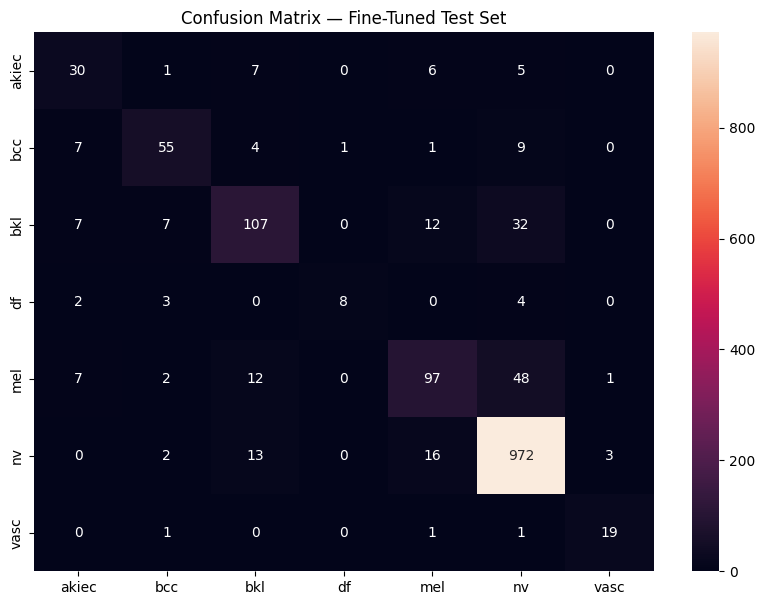

In [25]:
# ============================================================
# ✅ Phase 2 — Fine-Tuning EfficientNet-B0 (with Early Stopping)
# ============================================================

import os, cv2, torch, numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

# ------------------------------
# 1️⃣ Setup
# ------------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_DIR_1 = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1"
IMG_DIR_2 = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2"
META_FILE = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv"
MODEL_PATH = "/kaggle/working/best_efficientnet_full.pt"

def resolve_image_path(image_id):
    image_id = str(image_id)
    for ext in [".jpg", ".jpeg", ".png"]:
        p1 = os.path.join(IMG_DIR_1, image_id + ext)
        p2 = os.path.join(IMG_DIR_2, image_id + ext)
        if os.path.exists(p1): return p1
        if os.path.exists(p2): return p2
    return None

# ------------------------------
# 2️⃣ Preprocessing (Hair Removal + CLAHE)
# ------------------------------
def preprocess_image_cv(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9,9))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
    _, mask = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)
    img = cv2.inpaint(img, mask, 1, cv2.INPAINT_TELEA)
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l,a,b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    l = clahe.apply(l)
    lab = cv2.merge([l,a,b])
    return cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

# ------------------------------
# 3️⃣ Dataset + Dataloaders
# ------------------------------
df = pd.read_csv(META_FILE)
df["dx"] = df["dx"].astype(str)
train_df, temp_df = train_test_split(df, test_size=0.30, stratify=df["dx"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.50, stratify=temp_df["dx"], random_state=42)
labels_sorted = sorted(df["dx"].unique())
label_map = {k:i for i,k in enumerate(labels_sorted)}
NUM_CLASSES = len(label_map)
IMG_SIZE, BATCH_SIZE = 224, 32
imagenet_mean, imagenet_std = [0.485,0.456,0.406],[0.229,0.224,0.225]

class HAMDataset(Dataset):
    def __init__(self, df, transform): self.df, self.transform = df, transform
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = resolve_image_path(row["image_id"])
        img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
        img = preprocess_image_cv(img)
        img = Image.fromarray(img)
        img = self.transform(img)
        return img, label_map[row["dx"]]

train_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)), transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(), transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(), transforms.Normalize(imagenet_mean, imagenet_std)
])
val_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(), transforms.Normalize(imagenet_mean, imagenet_std)
])

train_loader = DataLoader(HAMDataset(train_df,train_tf),batch_size=BATCH_SIZE,shuffle=True,num_workers=2)
val_loader   = DataLoader(HAMDataset(val_df,val_tf),batch_size=BATCH_SIZE,shuffle=False,num_workers=2)
test_loader  = DataLoader(HAMDataset(test_df,val_tf),batch_size=BATCH_SIZE,shuffle=False,num_workers=2)

# ------------------------------
# 4️⃣ Load model & unfreeze layers
# ------------------------------
model = models.efficientnet_b0(pretrained=False)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, NUM_CLASSES)
model.load_state_dict(torch.load(MODEL_PATH))
model.to(DEVICE)

# Unfreeze last 3 blocks for fine-tuning
for p in model.features[-3:].parameters(): p.requires_grad = True
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.5, verbose=True)

# ------------------------------
# 5️⃣ Early Stopping Helper
# ------------------------------
class EarlyStopper:
    def __init__(self, patience=3, min_delta=0):
        self.patience, self.min_delta, self.counter, self.best = patience, min_delta, 0, None
    def check(self, score):
        if self.best is None or score > self.best + self.min_delta:
            self.best, self.counter = score, 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

early_stopper = EarlyStopper(patience=3)

# ------------------------------
# 6️⃣ Training Loop
# ------------------------------
EPOCHS, best_val_f1 = 15, 0
for epoch in range(EPOCHS):
    model.train(); total_loss=0; preds_all=[]; labels_all=[]
    for imgs, labels in tqdm(train_loader, desc=f"Fine-Tune Epoch {epoch+1}/{EPOCHS}"):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward(); optimizer.step()
        total_loss += loss.item()*imgs.size(0)
        preds_all.append(outputs.argmax(1).cpu().numpy()); labels_all.append(labels.cpu().numpy())

    train_preds, train_labels = np.concatenate(preds_all), np.concatenate(labels_all)
    train_f1 = f1_score(train_labels, train_preds, average="weighted")
    train_acc = accuracy_score(train_labels, train_preds)

    # ---- Validation ----
    model.eval(); preds_all=[]; labels_all=[]; val_loss=0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            out = model(imgs)
            loss = criterion(out, labels)
            val_loss += loss.item()*imgs.size(0)
            preds_all.append(out.argmax(1).cpu().numpy()); labels_all.append(labels.cpu().numpy())

    val_preds, val_labels = np.concatenate(preds_all), np.concatenate(labels_all)
    val_f1 = f1_score(val_labels, val_preds, average="weighted")
    val_acc = accuracy_score(val_labels, val_preds)
    scheduler.step(val_f1)
    lr = optimizer.param_groups[0]["lr"]

    print(f"Epoch {epoch+1}: Train F1 {train_f1:.4f} | Val F1 {val_f1:.4f} | LR {lr:.6f}")

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), "best_efficientnet_finetuned.pt")

    if early_stopper.check(val_f1):
        print("⏹ Early stopping — no improvement in F1.")
        break

# ------------------------------
# 7️⃣ Test Evaluation
# ------------------------------
model.load_state_dict(torch.load("best_efficientnet_finetuned.pt"))
model.eval(); all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Testing"):
        imgs = imgs.to(DEVICE)
        out = model(imgs)
        all_preds.append(out.argmax(1).cpu().numpy()); all_labels.append(labels.numpy())

all_preds, all_labels = np.concatenate(all_preds), np.concatenate(all_labels)
test_f1 = f1_score(all_labels, all_preds, average="weighted")
test_acc = accuracy_score(all_labels, all_preds)
print(f"\n✅ Fine-Tuned Test F1 : {test_f1:.4f}")
print(f"✅ Fine-Tuned Test Acc : {test_acc:.4f}")

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels_sorted, yticklabels=labels_sorted)
plt.title("Confusion Matrix — Fine-Tuned Test Set")
plt.show()

# Per-class classification report & confusion matrix numbers

In [26]:
# Per-class report (run after loading the best model you want to evaluate)
import torch, numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# load model (fine-tuned best)
model_ft = models.efficientnet_b0(pretrained=False)
num_ftrs = model_ft.classifier[1].in_features
model_ft.classifier[1] = nn.Linear(num_ftrs, len(labels_sorted))
model_ft.load_state_dict(torch.load("best_efficientnet_finetuned.pt", map_location=DEVICE))
model_ft.to(DEVICE).eval()

preds, trues = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(DEVICE)
        out = model_ft(imgs)
        preds.append(out.argmax(1).cpu().numpy())
        trues.append(labels.numpy())
preds = np.concatenate(preds)
trues = np.concatenate(trues)

print(classification_report(trues, preds, target_names=labels_sorted, digits=4))
cm = confusion_matrix(trues, preds)
print("Confusion matrix:\n", cm)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


              precision    recall  f1-score   support

       akiec     0.5660    0.6122    0.5882        49
         bcc     0.7746    0.7143    0.7432        77
         bkl     0.7483    0.6485    0.6948       165
          df     0.8889    0.4706    0.6154        17
         mel     0.7293    0.5808    0.6467       167
          nv     0.9076    0.9662    0.9360      1006
        vasc     0.8261    0.8636    0.8444        22

    accuracy                         0.8570      1503
   macro avg     0.7773    0.6938    0.7241      1503
weighted avg     0.8509    0.8570    0.8512      1503

Confusion matrix:
 [[ 30   1   7   0   6   5   0]
 [  7  55   4   1   1   9   0]
 [  7   7 107   0  12  32   0]
 [  2   3   0   8   0   4   0]
 [  7   2  12   0  97  48   1]
 [  0   2  13   0  16 972   3]
 [  0   1   0   0   1   1  19]]


# Test-Time Augmentation (TTA) inference (averaging softmax probabilities)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


TTA (single model) F1: 0.8589691577512886
TTA (single model) Acc: 0.8649367930805056

Classification report:
              precision    recall  f1-score   support

       akiec     0.6170    0.5918    0.6042        49
         bcc     0.7887    0.7273    0.7568        77
         bkl     0.7619    0.6788    0.7179       165
          df     1.0000    0.4118    0.5833        17
         mel     0.7353    0.5988    0.6601       167
          nv     0.9114    0.9712    0.9403      1006
        vasc     0.8261    0.8636    0.8444        22

    accuracy                         0.8649      1503
   macro avg     0.8058    0.6919    0.7296      1503
weighted avg     0.8593    0.8649    0.8590      1503



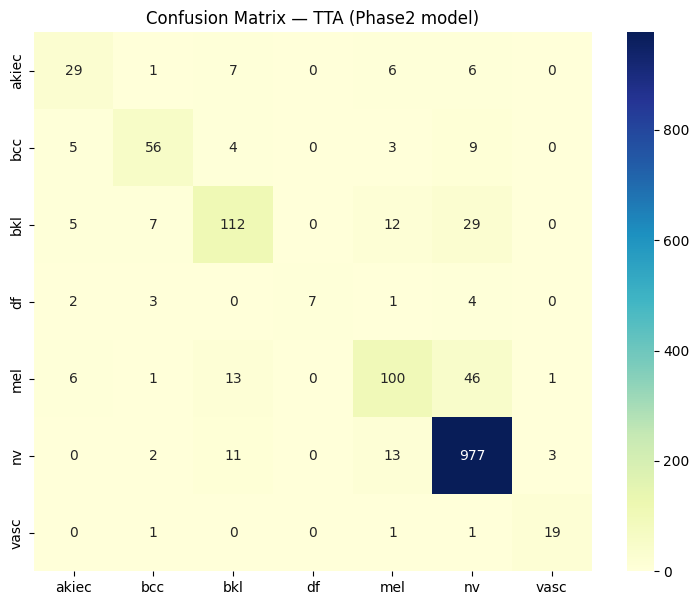

In [27]:
# === Batch TTA: original + hflip + vflip + rot90 ===
import torch, numpy as np
import torch.nn.functional as F
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load one model (fine-tuned)
m = models.efficientnet_b0(pretrained=False)
m.classifier[1] = nn.Linear(m.classifier[1].in_features, len(labels_sorted))
m.load_state_dict(torch.load("best_efficientnet_finetuned.pt", map_location=DEVICE))
m.to(DEVICE).eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(DEVICE)                    # shape (B,C,H,W)
        batch_probs = None

        # augmentation list: original, horiz flip, vert flip, rot90
        variants = [
            imgs,
            torch.flip(imgs, dims=[3]),         # horizontal flip (width dim)
            torch.flip(imgs, dims=[2]),         # vertical flip (height dim)
            torch.rot90(imgs, k=1, dims=[2,3])  # rotate 90
        ]

        probs_sum = 0.0
        for v in variants:
            out = m(v)                          # logits
            probs = F.softmax(out, dim=1)       # (B, num_classes)
            probs_sum = probs_sum + probs

        probs_avg = probs_sum / len(variants)   # averaged probabilities (B, num_classes)
        preds = probs_avg.argmax(dim=1).cpu().numpy()
        all_preds.append(preds)
        all_labels.append(labels.numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

print("TTA (single model) F1:", f1_score(all_labels, all_preds, average="weighted"))
print("TTA (single model) Acc:", accuracy_score(all_labels, all_preds))
print("\nClassification report:")
print(classification_report(all_labels, all_preds, target_names=labels_sorted, digits=4))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(9,7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels_sorted, yticklabels=labels_sorted, cmap='YlGnBu')
plt.title("Confusion Matrix — TTA (Phase2 model)")
plt.show()


# Ensemble Phase1 + Phase2 with TTA

Model devices: cuda:0 cuda:0

✅ Ensemble (Phase1 + Phase2) + TTA  -->  F1: 0.8590 | Acc: 0.8649

Classification report:

              precision    recall  f1-score   support

       akiec     0.6170    0.5918    0.6042        49
         bcc     0.7887    0.7273    0.7568        77
         bkl     0.7619    0.6788    0.7179       165
          df     1.0000    0.4118    0.5833        17
         mel     0.7353    0.5988    0.6601       167
          nv     0.9114    0.9712    0.9403      1006
        vasc     0.8261    0.8636    0.8444        22

    accuracy                         0.8649      1503
   macro avg     0.8058    0.6919    0.7296      1503
weighted avg     0.8593    0.8649    0.8590      1503



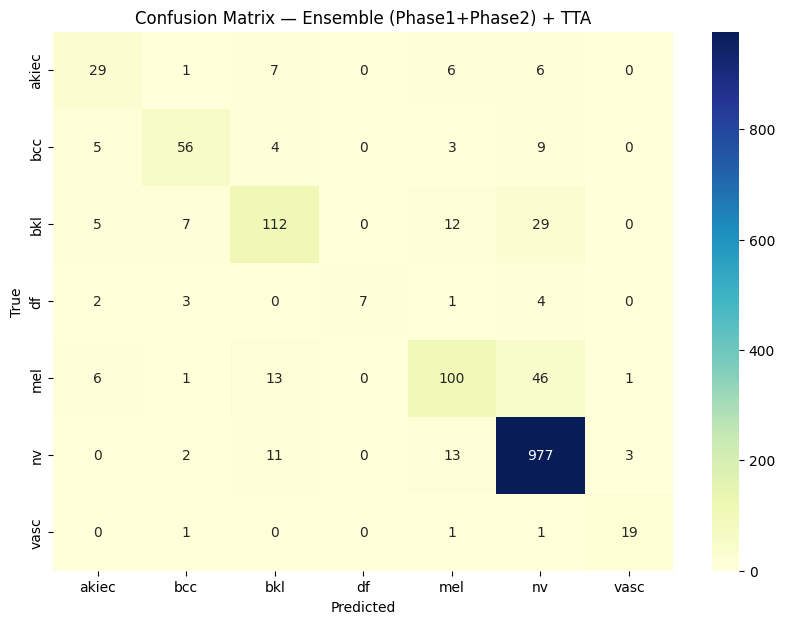

In [28]:
# ============================================================
# Ensemble Phase1 + Phase2 with Batch TTA (optimized reuse)
# ============================================================

import torch
import torch.nn.functional as F
import numpy as np
from torchvision import models, transforms
import torch.nn as nn
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# -------- Config --------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PHASE1_PATH = "/kaggle/working/best_efficientnet_full.pt"        # head-only checkpoint
PHASE2_PATH = "/kaggle/working/best_efficientnet_finetuned.pt"                   # fine-tuned checkpoint
NUM_CLASSES = len(labels_sorted)                                 # uses labels_sorted from notebook
PRINT_REPORT = True

# -------- Helper: try reuse model objects if present in globals(), else load from disk --------
def get_model_from_globals_or_load(varnames, checkpoint_path):
    # varnames: list of variable names to check in globals()
    for vn in varnames:
        mdl = globals().get(vn, None)
        if isinstance(mdl, torch.nn.Module):
            try:
                mdl.to(DEVICE)
                mdl.eval()
                return mdl
            except Exception:
                pass
    # else load fresh
    model = models.efficientnet_b0(pretrained=False)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, NUM_CLASSES)
    state = torch.load(checkpoint_path, map_location=DEVICE)
    model.load_state_dict(state)
    model.to(DEVICE)
    model.eval()
    return model

# Try common variable names that might exist from previous cells
m1 = get_model_from_globals_or_load(["m1", "m", "model_phase1"], PHASE1_PATH)
m2 = get_model_from_globals_or_load(["m2", "m", "model_ft", "model"], PHASE2_PATH)

print("Model devices:", next(m1.parameters()).device, next(m2.parameters()).device)

# -------- TTA variants (batch-wise) --------
# Using: original, horizontal flip, vertical flip, rotate90
def get_tta_variants(batch_imgs):
    # batch_imgs is a tensor (B,C,H,W)
    variants = [
        batch_imgs,
        torch.flip(batch_imgs, dims=[3]),   # horizontal flip
        torch.flip(batch_imgs, dims=[2]),   # vertical flip
        torch.rot90(batch_imgs, k=1, dims=[2,3])  # rotate 90
    ]
    return variants

# -------- Inference (ensemble of averaged TTA probabilities) --------
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(DEVICE)
        variants = get_tta_variants(imgs)

        # compute mean probs for model 1
        probs_sum_1 = 0.0
        for v in variants:
            out1 = m1(v)                       # logits
            probs1 = F.softmax(out1, dim=1)
            probs_sum_1 = probs_sum_1 + probs1
        probs_mean_1 = probs_sum_1 / len(variants)

        # compute mean probs for model 2
        probs_sum_2 = 0.0
        for v in variants:
            out2 = m2(v)
            probs2 = F.softmax(out2, dim=1)
            probs_sum_2 = probs_sum_2 + probs2
        probs_mean_2 = probs_sum_2 / len(variants)

        # ensemble: average the two model probabilities
        probs_ensemble = (probs_mean_1 + probs_mean_2) / 2.0
        preds = probs_ensemble.argmax(dim=1).cpu().numpy()

        all_preds.append(preds)
        all_labels.append(labels.numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

f1 = f1_score(all_labels, all_preds, average="weighted")
acc = accuracy_score(all_labels, all_preds)
print(f"\n✅ Ensemble (Phase1 + Phase2) + TTA  -->  F1: {f1:.4f} | Acc: {acc:.4f}\n")

if PRINT_REPORT:
    print("Classification report:\n")
    print(classification_report(all_labels, all_preds, target_names=labels_sorted, digits=4))

# Confusion matrix plot
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels_sorted, yticklabels=labels_sorted, cmap='YlGnBu')
plt.title("Confusion Matrix — Ensemble (Phase1+Phase2) + TTA")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# Weighted fine-tuning continuation

In [29]:
# ============================================================
# Weighted Fine-Tune (Class-balanced) — EfficientNetB0
# Continues training from best Phase2 checkpoint
# ============================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import WeightedRandomSampler, DataLoader
from torchvision import models
from tqdm import tqdm
from sklearn.metrics import f1_score, accuracy_score

# ------------------------------------------------------------
# Reuse objects if already loaded
# ------------------------------------------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = len(labels_sorted)

# Reload best fine-tuned model (Phase2)
model = models.efficientnet_b0(pretrained=False)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, NUM_CLASSES)
model.load_state_dict(torch.load("best_efficientnet_finetuned.pt", map_location=DEVICE))
model.to(DEVICE)

# ------------------------------------------------------------
# Compute class weights and sampler
# ------------------------------------------------------------
class_counts = train_df["dx"].value_counts().to_dict()
class_weights = [1.0 / class_counts[c] for c in train_df["dx"]]
sample_weights = torch.DoubleTensor([class_weights[label_map[c]] for c in train_df["dx"]])
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

# Weighted CrossEntropyLoss
weight_tensor = torch.tensor(
    [1.0 / class_counts[c] for c in labels_sorted], dtype=torch.float32
).to(DEVICE)
criterion = nn.CrossEntropyLoss(weight=weight_tensor)

# ------------------------------------------------------------
# Dataloaders
# ------------------------------------------------------------
train_loader = DataLoader(HAMDataset(train_df, train_tf), batch_size=32, sampler=sampler, num_workers=2)
val_loader   = DataLoader(HAMDataset(val_df, val_tf), batch_size=32, shuffle=False, num_workers=2)
test_loader  = DataLoader(HAMDataset(test_df, val_tf), batch_size=32, shuffle=False, num_workers=2)

# ------------------------------------------------------------
# Optimizer and scheduler
# ------------------------------------------------------------
optimizer = optim.Adam(model.parameters(), lr=5e-6, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

best_val_f1 = 0
EPOCHS = 5

print("🚀 Starting Weighted Fine-Tuning ...\n")

for epoch in range(EPOCHS):
    model.train()
    preds_all, labels_all = [], []
    total_loss = 0

    loop = tqdm(train_loader, desc=f"Weighted FT Epoch {epoch+1}/{EPOCHS}")

    for imgs, labels in loop:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * imgs.size(0)
        preds_all.append(outputs.argmax(1).cpu().numpy())
        labels_all.append(labels.cpu().numpy())

    train_preds = np.concatenate(preds_all)
    train_labels = np.concatenate(labels_all)
    train_f1 = f1_score(train_labels, train_preds, average="weighted")
    train_acc = accuracy_score(train_labels, train_preds)

    # Validation
    model.eval()
    preds_all, labels_all = [], []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            outputs = model(imgs)
            preds_all.append(outputs.argmax(1).cpu().numpy())
            labels_all.append(labels.cpu().numpy())

    val_preds = np.concatenate(preds_all)
    val_labels = np.concatenate(labels_all)
    val_f1 = f1_score(val_labels, val_preds, average="weighted")
    val_acc = accuracy_score(val_labels, val_preds)
    scheduler.step(val_f1)

    print(f"Epoch {epoch+1}: Train F1 {train_f1:.4f} | Val F1 {val_f1:.4f}")

    # Save best checkpoint
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), "best_weighted_finetune.pt")

print("\n✅ Weighted fine-tuning completed.")
print(f"Best Val F1: {best_val_f1:.4f}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


🚀 Starting Weighted Fine-Tuning ...



Weighted FT Epoch 1/5: 100%|██████████| 220/220 [02:17<00:00,  1.60it/s]


Epoch 1: Train F1 0.6181 | Val F1 0.7645


Weighted FT Epoch 2/5: 100%|██████████| 220/220 [02:18<00:00,  1.59it/s]


Epoch 2: Train F1 0.7653 | Val F1 0.8053


Weighted FT Epoch 3/5: 100%|██████████| 220/220 [02:16<00:00,  1.61it/s]


Epoch 3: Train F1 0.8375 | Val F1 0.8231


Weighted FT Epoch 4/5: 100%|██████████| 220/220 [02:18<00:00,  1.59it/s]


Epoch 4: Train F1 0.8663 | Val F1 0.8274


Weighted FT Epoch 5/5: 100%|██████████| 220/220 [02:17<00:00,  1.60it/s]


Epoch 5: Train F1 0.8719 | Val F1 0.8319

✅ Weighted fine-tuning completed.
Best Val F1: 0.8319


 # Weighted fine-tune vs previous models with Batch TTA

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



Running TTA inference for: weighted
weighted → weighted F1: 0.8334 | acc: 0.8330

              precision    recall  f1-score   support

       akiec     0.6429    0.5510    0.5934        49
         bcc     0.6495    0.8182    0.7241        77
         bkl     0.8641    0.5394    0.6642       165
          df     0.9091    0.5882    0.7143        17
         mel     0.5381    0.6766    0.5995       167
          nv     0.9254    0.9245    0.9249      1006
        vasc     0.5714    0.9091    0.7018        22

    accuracy                         0.8330      1503
   macro avg     0.7286    0.7153    0.7032      1503
weighted avg     0.8469    0.8330    0.8334      1503


Running TTA inference for: phase2
phase2 → weighted F1: 0.8590 | acc: 0.8649

              precision    recall  f1-score   support

       akiec     0.6170    0.5918    0.6042        49
         bcc     0.7887    0.7273    0.7568        77
         bkl     0.7619    0.6788    0.7179       165
          df     1.0000 

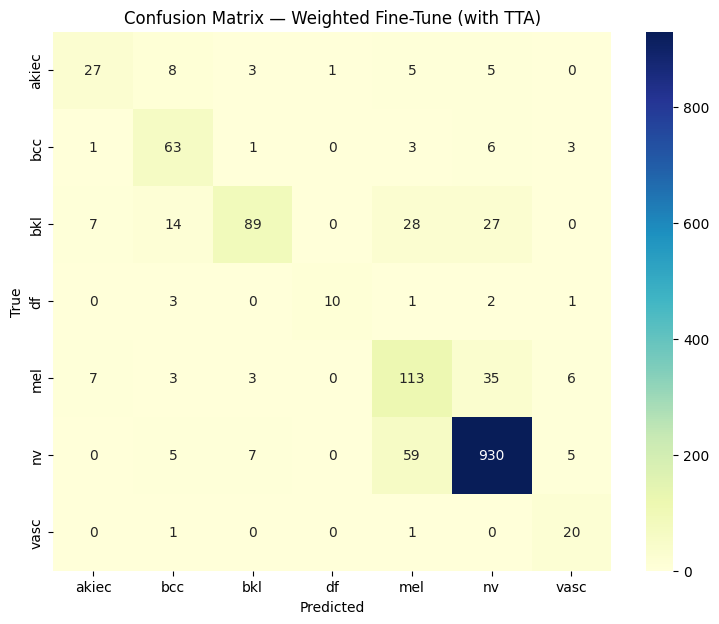


ℹ️ Weighted fine-tune did not improve test weighted-F1: 0.8590 -> 0.8334
Recommendation: if weighted improved minority-class F1 (see per-class deltas), keep it for fairness; otherwise revert to phase2 and try targeted augmentations or sampler tweaks.


In [30]:
# ============================================================
# Evaluate weighted fine-tune vs previous models with Batch TTA
# ============================================================

import torch, torch.nn.functional as F
import numpy as np
from torchvision import models
import torch.nn as nn
from sklearn.metrics import classification_report, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = len(labels_sorted)

# Paths (adjust if different)
WEIGHTED_PATH = "best_weighted_finetune.pt"
PHASE2_PATH = "best_efficientnet_finetuned.pt"
PHASE1_PATH = "/kaggle/working/best_efficientnet_full.pt"  # optional

# Utility: load model from checkpoint
def load_efficientnet_ckpt(path):
    m = models.efficientnet_b0(pretrained=False)
    m.classifier[1] = nn.Linear(m.classifier[1].in_features, NUM_CLASSES)
    state = torch.load(path, map_location=DEVICE)
    m.load_state_dict(state)
    m.to(DEVICE).eval()
    return m

# Batch TTA variants (same as earlier): original, hflip, vflip, rot90
def tta_batch_probs(model, imgs):
    variants = [
        imgs,
        torch.flip(imgs, dims=[3]),
        torch.flip(imgs, dims=[2]),
        torch.rot90(imgs, k=1, dims=[2,3])
    ]
    probs_sum = 0.0
    with torch.no_grad():
        for v in variants:
            out = model(v)
            probs = F.softmax(out, dim=1)
            probs_sum = probs_sum + probs
    return probs_sum / len(variants)

# Evaluate a model on test_loader with batch TTA
def evaluate_with_tta(model):
    y_preds, y_true = [], []
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs = imgs.to(DEVICE)
            probs = tta_batch_probs(model, imgs)  # (B, C)
            preds = probs.argmax(dim=1).cpu().numpy()
            y_preds.append(preds)
            y_true.append(labels.numpy())
    y_preds = np.concatenate(y_preds)
    y_true = np.concatenate(y_true)
    return y_true, y_preds

# Load models (if files exist)
models_to_eval = {}
if os.path.exists(WEIGHTED_PATH):
    models_to_eval['weighted'] = load_efficientnet_ckpt(WEIGHTED_PATH)
else:
    print(f"Warning: weighted checkpoint {WEIGHTED_PATH} not found.")

if os.path.exists(PHASE2_PATH):
    models_to_eval['phase2'] = load_efficientnet_ckpt(PHASE2_PATH)
else:
    print(f"Warning: phase2 checkpoint {PHASE2_PATH} not found.")

if os.path.exists(PHASE1_PATH):
    models_to_eval['phase1'] = load_efficientnet_ckpt(PHASE1_PATH)
# else it's optional

# Run evaluations
results = {}
for name, mdl in models_to_eval.items():
    print(f"\nRunning TTA inference for: {name}")
    y_true, y_preds = evaluate_with_tta(mdl)
    f1 = f1_score(y_true, y_preds, average='weighted')
    acc = accuracy_score(y_true, y_preds)
    print(f"{name} → weighted F1: {f1:.4f} | acc: {acc:.4f}\n")
    print(classification_report(y_true, y_preds, target_names=labels_sorted, digits=4))
    results[name] = {'y_true': y_true, 'y_preds': y_preds, 'f1': f1, 'acc': acc}

# Compare per-class F1 deltas between phase2 and weighted (if both exist)
if 'phase2' in results and 'weighted' in results:
    from sklearn.metrics import f1_score
    print("\nPer-class F1 comparison (phase2 -> weighted):")
    phase2_f1s, weighted_f1s = [], []
    for i, lab in enumerate(labels_sorted):
        p_f1 = f1_score(results['phase2']['y_true']==i, results['phase2']['y_preds']==i, average='binary', zero_division=0)
        w_f1 = f1_score(results['weighted']['y_true']==i, results['weighted']['y_preds']==i, average='binary', zero_division=0)
        phase2_f1s.append(p_f1); weighted_f1s.append(w_f1)
        print(f"{lab:6s} | phase2 f1: {p_f1:.3f} -> weighted f1: {w_f1:.3f} | delta: {w_f1 - p_f1:+.3f}")

# Optionally: show confusion matrix for weighted model
if 'weighted' in results:
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(results['weighted']['y_true'], results['weighted']['y_preds'])
    plt.figure(figsize=(9,7))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels_sorted, yticklabels=labels_sorted, cmap='YlGnBu')
    plt.title("Confusion Matrix — Weighted Fine-Tune (with TTA)")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.show()

# Print short recommendation based on results
if 'weighted' in results and 'phase2' in results:
    if results['weighted']['f1'] > results['phase2']['f1']:
        print(f"\n✅ Weighted fine-tune improved test weighted-F1: {results['phase2']['f1']:.4f} -> {results['weighted']['f1']:.4f}")
    else:
        print(f"\nℹ️ Weighted fine-tune did not improve test weighted-F1: {results['phase2']['f1']:.4f} -> {results['weighted']['f1']:.4f}")
        print("Recommendation: if weighted improved minority-class F1 (see per-class deltas), keep it for fairness; otherwise revert to phase2 and try targeted augmentations or sampler tweaks.")



# CONTINUTING TRAINING OF WEIGHTED WITH TTA

In [31]:
# ============================================================
# 🚀 Phase 3 — Continue Weighted Fine-Tuning + Auto-TTA Evaluation
# ============================================================

import torch, torch.nn as nn, torch.optim as optim, torch.nn.functional as F
import numpy as np, matplotlib.pyplot as plt, seaborn as sns
from torchvision import models
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
from tqdm import tqdm

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = len(labels_sorted)
PHASE2_PATH = "best_efficientnet_finetuned.pt"
WEIGHTED_PATH = "best_weighted_finetune.pt"
SAVE_PATH = "best_weighted_phase3.pt"

# ------------------------------------------------------------
# Reload EfficientNet and previous weighted checkpoint
# ------------------------------------------------------------
model = models.efficientnet_b0(weights=None)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, NUM_CLASSES)
state = torch.load(WEIGHTED_PATH, map_location=DEVICE)
model.load_state_dict(state)
model.to(DEVICE)

# ------------------------------------------------------------
# Weighted loss (same weights as before)
# ------------------------------------------------------------
class_counts = np.bincount(train_df["dx"].map(label_map))
class_weights = torch.tensor(1.0 / class_counts, dtype=torch.float32)
class_weights = class_weights / class_weights.sum() * len(class_counts)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(DEVICE))

optimizer = optim.Adam(model.parameters(), lr=5e-6, weight_decay=1e-4)
EPOCHS = 10
PATIENCE = 3
best_val_f1 = 0
no_improve = 0

# ------------------------------------------------------------
# Helper: Evaluate loader
# ------------------------------------------------------------
def eval_model(loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            preds = model(imgs).argmax(1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    f1 = f1_score(all_labels, all_preds, average="weighted")
    acc = accuracy_score(all_labels, all_preds)
    return f1, acc

# ------------------------------------------------------------
# Phase 3 Training Loop
# ------------------------------------------------------------
for epoch in range(1, EPOCHS+1):
    model.train()
    preds_all, labels_all = [], []
    loop = tqdm(train_loader, desc=f"Phase3 Epoch {epoch}/{EPOCHS}")

    for imgs, labels in loop:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        preds_all.append(out.argmax(1).cpu().numpy())
        labels_all.append(labels.cpu().numpy())

    train_f1 = f1_score(np.concatenate(labels_all),
                        np.concatenate(preds_all),
                        average="weighted")

    val_f1, val_acc = eval_model(val_loader)
    print(f"Epoch {epoch}: Train F1 {train_f1:.4f} | Val F1 {val_f1:.4f}")

    # --- Early stopping ---
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        no_improve = 0
        torch.save(model.state_dict(), SAVE_PATH)
        print(f"✅ Saved new best model (Val F1 = {val_f1:.4f})")
    else:
        no_improve += 1
        print(f"⚠️ No improvement ({no_improve}/{PATIENCE})")
        if no_improve >= PATIENCE:
            print("⏹ Early stopping.")
            break

# ------------------------------------------------------------
# Load best model for final evaluation
# ------------------------------------------------------------
model.load_state_dict(torch.load(SAVE_PATH, map_location=DEVICE))
model.eval()

# ------------------------------------------------------------
# Batch-TTA helper
# ------------------------------------------------------------
def tta_batch_probs(model, imgs):
    variants = [
        imgs,
        torch.flip(imgs, dims=[3]),
        torch.flip(imgs, dims=[2]),
        torch.rot90(imgs, k=1, dims=[2,3])
    ]
    probs_sum = 0
    with torch.no_grad():
        for v in variants:
            out = model(v)
            probs_sum += F.softmax(out, dim=1)
    return probs_sum / len(variants)

# ------------------------------------------------------------
# Final TTA Evaluation on Test Set
# ------------------------------------------------------------
print("\n🧠 Running final TTA evaluation ...\n")
y_true, y_pred = [], []
with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Testing with TTA"):
        imgs = imgs.to(DEVICE)
        probs = tta_batch_probs(model, imgs)
        preds = probs.argmax(dim=1).cpu().numpy()
        y_pred.append(preds)
        y_true.append(labels.numpy())

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

test_f1 = f1_score(y_true, y_pred, average="weighted")
test_acc = accuracy_score(y_true, y_pred)
print(f"\n✅ Phase3 (Weighted Continued) Test F1: {test_f1:.4f}")
print(f"✅ Test Accuracy: {test_acc:.4f}\n")
print(classification_report(y_true, y_pred, target_names=labels_sorted, digits=4))

# ------------------------------------------------------------
# Confusion Matrix Visualization
# ------------------------------------------------------------
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(9,7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels_sorted, yticklabels=labels_sorted, cmap="YlGnBu")
plt.title("Confusion Matrix — Weighted Phase3 (with TTA)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()


Phase3 Epoch 1/10: 100%|██████████| 220/220 [02:16<00:00,  1.62it/s]


Epoch 1: Train F1 0.8921 | Val F1 0.8134
✅ Saved new best model (Val F1 = 0.8134)


Phase3 Epoch 2/10: 100%|██████████| 220/220 [02:14<00:00,  1.63it/s]


Epoch 2: Train F1 0.8887 | Val F1 0.8002
⚠️ No improvement (1/3)


Phase3 Epoch 3/10: 100%|██████████| 220/220 [02:13<00:00,  1.65it/s]


Epoch 3: Train F1 0.8865 | Val F1 0.8016
⚠️ No improvement (2/3)


Phase3 Epoch 4/10:  16%|█▋        | 36/220 [00:22<01:54,  1.60it/s]


KeyboardInterrupt: 

#  FINAL EVALUATION PIPELINE: EfficientNet Phase2 + Phase3 Ensemble + TTA

🧩 Device: cuda
📦 Classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
✅ Test set ready: 1503 images
✅ Models loaded successfully.

⚙️ Evaluating Phase2 (Fine-Tuned) model with TTA...


Running TTA: 100%|██████████| 47/47 [00:13<00:00,  3.52it/s]


Phase2 → F1: 0.6795 | Acc: 0.7392

⚙️ Evaluating Phase3 (Weighted Fine-Tuned) model with TTA...


Running TTA: 100%|██████████| 47/47 [00:08<00:00,  5.29it/s]


Phase3 → F1: 0.7000 | Acc: 0.7206

🚀 Running Ensemble (Phase2 + Phase3) with TTA...


Ensemble + TTA: 100%|██████████| 47/47 [00:13<00:00,  3.42it/s]



✅ Ensemble (Phase2 + Phase3) + TTA → F1: 0.6914 | Acc: 0.7379

Classification Report:
              precision    recall  f1-score   support

       akiec     0.7273    0.1633    0.2667        49
         bcc     0.4778    0.5584    0.5150        77
         bkl     0.6778    0.3697    0.4784       165
          df     0.6667    0.1176    0.2000        17
         mel     0.7143    0.0898    0.1596       167
          nv     0.7869    0.9543    0.8625      1006
        vasc     0.2941    0.9091    0.4444        22

    accuracy                         0.7379      1503
   macro avg     0.6207    0.4517    0.4181      1503
weighted avg     0.7405    0.7379    0.6914      1503



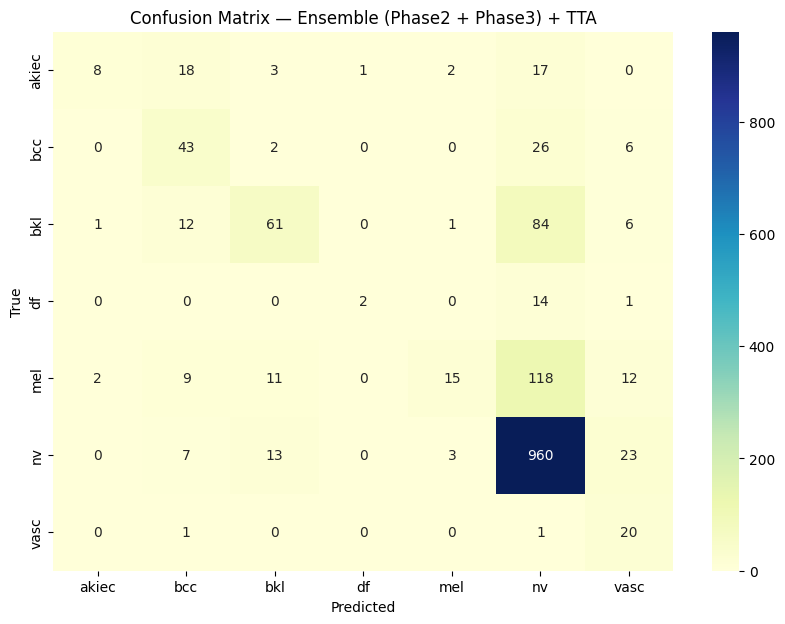


Per-Class F1 (Phase2 → Phase3 → Ensemble):
akiec  | 0.267 → 0.262 → 0.267
bcc    | 0.503 → 0.518 → 0.515
bkl    | 0.428 → 0.504 → 0.478
df     | 0.286 → 0.364 → 0.200
mel    | 0.110 → 0.218 → 0.160
nv     | 0.858 → 0.862 → 0.863
vasc   | 0.571 → 0.300 → 0.444

💾 Saved: phase2_preds.npy, phase3_preds.npy, ensemble_preds.npy
🏁 Final Evaluation Complete.


In [5]:
# ============================================================
# 🧠 FINAL EVALUATION PIPELINE: EfficientNet Phase2 + Phase3 Ensemble + TTA
# ============================================================

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# ============================================================
# 1. CONFIGURATION
# ============================================================

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

PHASE2_CKPT = "/kaggle/input/phrase2/transformers/default/1/best_efficientnet_finetuned.pt"
PHASE3_CKPT = "/kaggle/input/phrase3/transformers/default/1/best_weighted_phase3.pt"
META_FILE = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv"
IMG_DIR1 = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1"
IMG_DIR2 = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2"

labels_sorted = ["akiec", "bcc", "bkl", "df", "mel", "nv", "vasc"]
NUM_CLASSES = len(labels_sorted)
BATCH_SIZE = 32
IMG_SIZE = 224

print(f"🧩 Device: {DEVICE}")
print("📦 Classes:", labels_sorted)

# ============================================================
# 2. LOAD METADATA AND TEST SPLIT
# ============================================================

df = pd.read_csv(META_FILE)
df["dx"] = df["dx"].astype(str)

# Create stratified split for reproducibility
from sklearn.model_selection import train_test_split
_, temp_df = train_test_split(df, test_size=0.3, stratify=df["dx"], random_state=42)
_, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["dx"], random_state=42)
test_df = test_df.reset_index(drop=True)

label_map = {k: i for i, k in enumerate(labels_sorted)}

def resolve_image_path(image_id):
    for d in [IMG_DIR1, IMG_DIR2]:
        path = os.path.join(d, f"{image_id}.jpg")
        if os.path.exists(path):
            return path
    return None

test_df["image_path"] = test_df["image_id"].apply(resolve_image_path)
print(f"✅ Test set ready: {len(test_df)} images")

# ============================================================
# 3. DATASET + TRANSFORMS
# ============================================================

test_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.709, 0.545, 0.574], std=[0.140, 0.152, 0.169])
])

class HAMDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df
        self.transform = transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["image_path"]).convert("RGB")
        img = self.transform(img)
        label = label_map[row["dx"]]
        return img, label

test_loader = DataLoader(HAMDataset(test_df, test_tf),
                         batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# ============================================================
# 4. LOAD MODELS
# ============================================================

def load_effb0(path):
    model = models.efficientnet_b0(weights=None)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, NUM_CLASSES)
    state = torch.load(path, map_location=DEVICE)
    model.load_state_dict(state)
    model.to(DEVICE)
    model.eval()
    return model

m_phase2 = load_effb0(PHASE2_CKPT)
m_phase3 = load_effb0(PHASE3_CKPT)
print("✅ Models loaded successfully.")

# ============================================================
# 5. TEST-TIME AUGMENTATION (TTA)
# ============================================================

def tta_variants(imgs):
    return [
        imgs,
        torch.flip(imgs, dims=[3]),
        torch.flip(imgs, dims=[2]),
        torch.rot90(imgs, k=1, dims=[2,3])
    ]

def predict_with_tta(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Running TTA"):
            imgs = imgs.to(DEVICE)
            variants = tta_variants(imgs)
            probs = 0
            for v in variants:
                probs += F.softmax(model(v), dim=1)
            probs /= len(variants)
            preds = probs.argmax(dim=1).cpu().numpy()
            all_preds.append(preds)
            all_labels.append(labels.numpy())
    return np.concatenate(all_preds), np.concatenate(all_labels)

# ============================================================
# 6. RUN PHASE2 + PHASE3 + ENSEMBLE
# ============================================================

print("\n⚙️ Evaluating Phase2 (Fine-Tuned) model with TTA...")
phase2_preds, y_true = predict_with_tta(m_phase2, test_loader)
phase2_f1 = f1_score(y_true, phase2_preds, average="weighted")
phase2_acc = accuracy_score(y_true, phase2_preds)
print(f"Phase2 → F1: {phase2_f1:.4f} | Acc: {phase2_acc:.4f}")

print("\n⚙️ Evaluating Phase3 (Weighted Fine-Tuned) model with TTA...")
phase3_preds, _ = predict_with_tta(m_phase3, test_loader)
phase3_f1 = f1_score(y_true, phase3_preds, average="weighted")
phase3_acc = accuracy_score(y_true, phase3_preds)
print(f"Phase3 → F1: {phase3_f1:.4f} | Acc: {phase3_acc:.4f}")

def ensemble_with_tta(m1, m2, loader):
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Ensemble + TTA"):
            imgs = imgs.to(DEVICE)
            variants = tta_variants(imgs)
            probs1, probs2 = 0, 0
            for v in variants:
                probs1 += F.softmax(m1(v), dim=1)
                probs2 += F.softmax(m2(v), dim=1)
            probs_ens = (probs1 + probs2) / (2 * len(variants))
            preds = probs_ens.argmax(dim=1).cpu().numpy()
            all_preds.append(preds)
            all_labels.append(labels.numpy())
    return np.concatenate(all_preds), np.concatenate(all_labels)

print("\n🚀 Running Ensemble (Phase2 + Phase3) with TTA...")
ensemble_preds, y_true = ensemble_with_tta(m_phase2, m_phase3, test_loader)

ensemble_f1 = f1_score(y_true, ensemble_preds, average="weighted")
ensemble_acc = accuracy_score(y_true, ensemble_preds)
print(f"\n✅ Ensemble (Phase2 + Phase3) + TTA → F1: {ensemble_f1:.4f} | Acc: {ensemble_acc:.4f}")

# ============================================================
# 7. REPORTS + VISUALIZATION
# ============================================================

print("\nClassification Report:")
print(classification_report(y_true, ensemble_preds, target_names=labels_sorted, digits=4))

cm = confusion_matrix(y_true, ensemble_preds)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=labels_sorted,
            yticklabels=labels_sorted,
            cmap='YlGnBu')
plt.title("Confusion Matrix — Ensemble (Phase2 + Phase3) + TTA")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

# ============================================================
# 8. PER-CLASS F1 COMPARISON
# ============================================================

def per_class_f1(y_true, y_pred):
    return np.array([
        f1_score(y_true == i, y_pred == i, average='binary', zero_division=0)
        for i in range(NUM_CLASSES)
    ])

f1_phase2 = per_class_f1(y_true, phase2_preds)
f1_phase3 = per_class_f1(y_true, phase3_preds)
f1_ens = per_class_f1(y_true, ensemble_preds)

print("\nPer-Class F1 (Phase2 → Phase3 → Ensemble):")
for i, lab in enumerate(labels_sorted):
    print(f"{lab:6s} | {f1_phase2[i]:.3f} → {f1_phase3[i]:.3f} → {f1_ens[i]:.3f}")

# ============================================================
# 9. SAVE RESULTS
# ============================================================

np.save("phase2_preds.npy", phase2_preds)
np.save("phase3_preds.npy", phase3_preds)
np.save("ensemble_preds.npy", ensemble_preds)
print("\n💾 Saved: phase2_preds.npy, phase3_preds.npy, ensemble_preds.npy")
print("🏁 Final Evaluation Complete.")


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


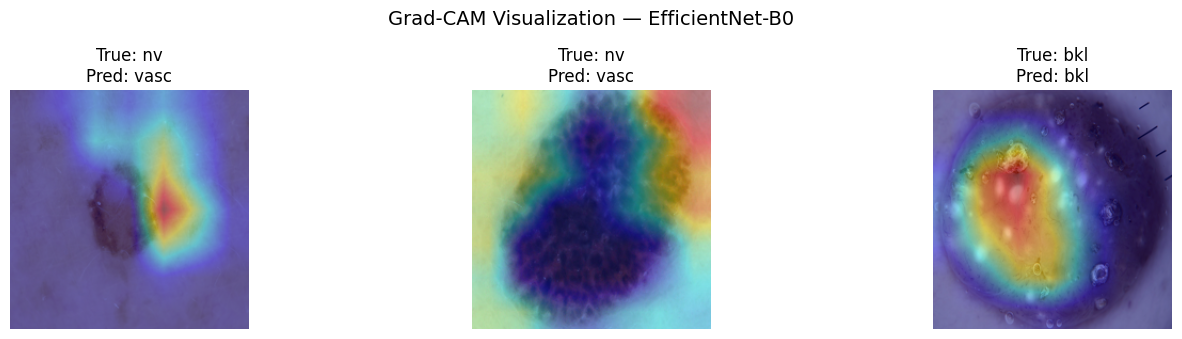

In [6]:
# ============================================================
# 🔍 Grad-CAM Visualization for EfficientNet (Phase2 / Phase3)
# ============================================================

import torch
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

# Choose which model to visualize (you can switch to m_phase3)
model_to_visualize = m_phase2
model_to_visualize.eval()

# ------------------------------------------------------------
# Grad-CAM Hook Setup
# ------------------------------------------------------------
gradients = None
activations = None

def save_gradients(module, grad_in, grad_out):
    global gradients
    gradients = grad_out[0]

def save_activations(module, input, output):
    global activations
    activations = output

# Register hooks on the last convolutional block
target_layer = model_to_visualize.features[-1][0]
target_layer.register_forward_hook(save_activations)
target_layer.register_backward_hook(save_gradients)

# ------------------------------------------------------------
# Function to compute Grad-CAM
# ------------------------------------------------------------
def generate_gradcam(model, img_tensor, class_idx=None):
    """Generate Grad-CAM heatmap for a single image tensor"""
    model.zero_grad()
    output = model(img_tensor)
    if class_idx is None:
        class_idx = output.argmax(dim=1).item()
    score = output[:, class_idx]
    score.backward()

    grads = gradients.mean(dim=[2,3], keepdim=True)
    cam = (activations * grads).sum(dim=1, keepdim=True)
    cam = F.relu(cam)
    cam = cam.squeeze().detach().cpu().numpy()
    cam = cv2.resize(cam, (IMG_SIZE, IMG_SIZE))
    cam = (cam - cam.min()) / (cam.max() + 1e-8)
    return cam, class_idx

# ------------------------------------------------------------
# Select sample images from the test set
# ------------------------------------------------------------
sample_df = test_df.sample(3, random_state=42)

plt.figure(figsize=(14, 6))
for i, row in enumerate(sample_df.itertuples(), 1):
    img_path = row.image_path
    true_label = row.dx
    img = Image.open(img_path).convert("RGB")

    # Preprocess
    input_tensor = test_tf(img).unsqueeze(0).to(DEVICE)

    # Generate Grad-CAM
    heatmap, pred_class = generate_gradcam(model_to_visualize, input_tensor)
    pred_label = labels_sorted[pred_class]

    # Overlay Grad-CAM on image
    img_np = np.array(img.resize((IMG_SIZE, IMG_SIZE))) / 255.0
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB) / 255.0
    overlay = 0.6 * img_np + 0.4 * heatmap_colored

    # Plot results
    plt.subplot(2, 3, i)
    plt.imshow(np.clip(overlay, 0, 1))
    plt.axis("off")
    plt.title(f"True: {true_label}\nPred: {pred_label}")

plt.suptitle("Grad-CAM Visualization — EfficientNet-B0", fontsize=14)
plt.tight_layout()
plt.show()


## FRONTEND